In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[-2]).unwrapped
discrete_actions = False

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
input_num = (len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))*2)
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
all_a = 0#.001

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    #squared = p_fitness - np.min(p_fitness)
    #squared = squared*squared
    #pick_probabilities = get_pick_probabilities(squared)
    #choice = np.random.choice(pick_probabilities.size,population_out_size+1, p = pick_probabilities)
    
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/3
        ex = ex**(1/(i+1))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    print("Choice : {}".format(choice))
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,all_a,device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_loss_all = []
    dis_loss_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r = dis(real_batch).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r,rank))
            dis_error_real.backward()
            dis_optimizer.step() 
            
            #generate children from population
            child = gen_children(population,device,gen,batch_size,a = all_a)
            
            #train generator
            dis_out_f = dis(child).squeeze(-1)
            gen_optimizer.zero_grad()
            gen_error = -torch.mean(dis_out_f)
            gen_error.backward()
            gen_optimizer.step() 
            
            #keep losses to draw graph   
            gen_loss_all.append(gen_error)
            dis_loss_all.append(dis_error_real)   
            
    return gen_loss_all, dis_loss_all

def softmax(x):
    e = 2.71828
    return e ** (x - max(x)) / sum(e**(x - max(x)))

starting training
2904
population fitness : [ -24.01271176  -98.51069425  -33.33579788 -113.3025865   -27.22050283
 -120.33552897 -110.9421873  -125.12170459  -27.85407049 -111.90555176]
mean fit : -79.25413363121399
[0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1]
5.278025237463137
Evolving...
Choice : [4, 8, 0, 6, 5, 2, 1, 3, 0, 9, 0]


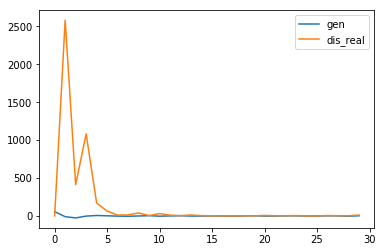

Generation 1  fitness : -24.01271176219792
#################################
population fitness : [-102.93983934  -97.53956819 -112.81163418  -92.58973487  -22.42824666
  -91.43388264  -93.90407676 -111.68772117  -21.87710922 -109.48358379]
mean fit : -85.66953968163033
[0.  0.1 0.  0.  0.  0.  0.1 0.1 0.  0. ]
5.114442137677689
Evolving...
Choice : [8, 6, 9, 5, 8, 4, 0, 3, 8, 1, 7]


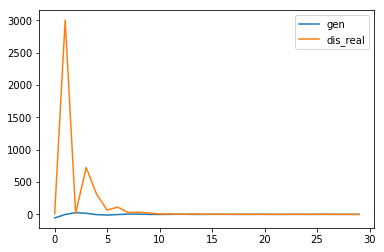

Generation 2  fitness : -21.877109220080694
#################################
population fitness : [ -97.78944261  -10.68650182 -112.5547052  -100.67133776 -111.60622603
  -25.31874847  -26.07539856  -93.59576564  -36.20083237  -93.01449148]
mean fit : -70.75134499339165
[0.1 0.  0.1 0.  0.1 0.  0.1 0.1 0.  0.1]
5.281728437873981
Evolving...
Choice : [1, 0, 4, 8, 1, 9, 7, 5, 3, 1, 6]


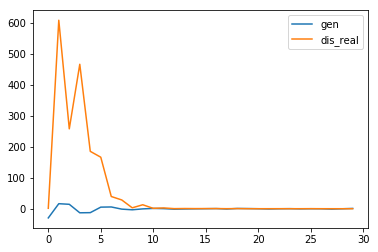

Generation 3  fitness : -10.686501816281524
#################################
population fitness : [ -93.17695408 -111.8977884  -111.73811103  -94.38061215  -92.99463943
  -95.37044233  -12.47089636 -100.74182389 -112.57887321  -93.47364537]
mean fit : -91.8823786254982
[0.  0.1 0.  0.  0.1 0.  0.1 0.  0.1 0. ]
5.058060439855944
Evolving...
Choice : [4, 6, 3, 5, 6, 1, 6, 0, 9, 7, 2]


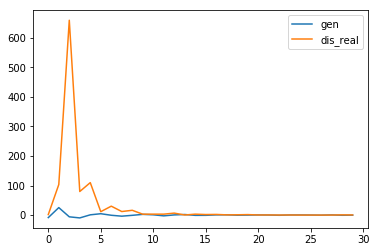

Generation 4  fitness : -12.470896358881166
#################################
population fitness : [ -93.56335994  -33.18819655  -93.02584156  -55.93607816 -112.9272207
 -113.90782307  -93.47246182  -93.68336326  -16.27709793 -102.11061612]
mean fit : -80.80920591031364
[0.1 0.  0.  0.1 0.1 0.1 0.  0.1 0.  0. ]
5.208518779232026
Evolving...
Choice : [4, 8, 3, 0, 7, 1, 9, 2, 8, 8, 6]


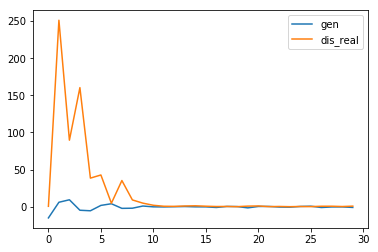

Generation 5  fitness : -16.277097931581128
#################################
population fitness : [-101.79830825  -96.54969699 -106.30945132  -93.97461279 -109.23817994
  -28.73790497 -112.29627014 -104.02516927  -19.63064025  -93.16191622]
mean fit : -86.57221501516419
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0. ]
5.077368008887334
Evolving...
Choice : [3, 8, 7, 8, 1, 0, 9, 2, 5, 8, 4]


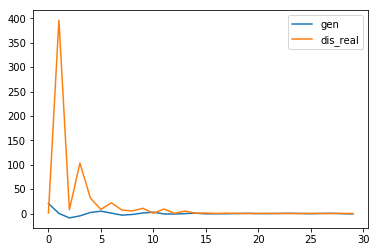

Generation 6  fitness : -19.630640250523797
#################################
population fitness : [ -10.32563631  -19.3603731  -104.87438013  -97.9598982   -93.20924476
 -118.0692054   -93.5028983   -35.07675387  -93.14792038  -95.25388421]
mean fit : -76.07801946433625
[0.  0.  0.1 0.  0.1 0.1 0.  0.  0.1 0.1]
5.258946001798591
Evolving...
Choice : [9, 0, 3, 2, 1, 0, 0, 4, 8, 6, 7]


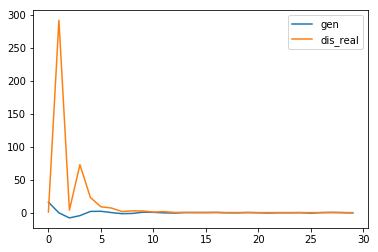

Generation 7  fitness : -10.325636310801725
#################################
population fitness : [ -93.9181186   -93.57534519 -100.25285994 -104.339016    -99.42876639
  -18.21180199 -113.41698091  -23.37131826  -93.12629854 -112.64146338]
mean fit : -85.22819691988981
[0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.1]
5.140828796533213
Evolving...
Choice : [9, 0, 2, 1, 3, 7, 8, 5, 5, 4, 5]


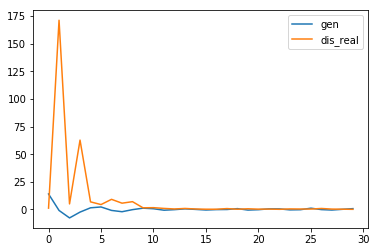

Generation 8  fitness : -18.21180199155709
#################################
population fitness : [-111.51619573 -113.47778282  -97.99605515 -100.9922541   -22.345404
  -94.99888134  -23.70623579  -32.86111608  -12.62114014  -94.08164315]
mean fit : -70.45967083030966
[0.  0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0. ]
5.272447628790447
Evolving...
Choice : [6, 9, 2, 5, 4, 8, 7, 3, 0, 8, 8]


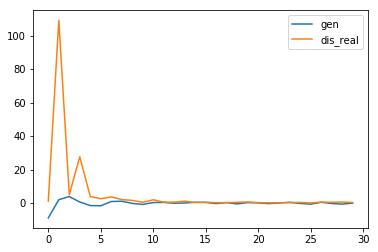

Generation 9  fitness : -12.621140136695775
#################################
population fitness : [ -13.0455257   -93.43174058  -92.87718386 -123.254402    -99.44624161
  -95.23832699 -111.18238901  -93.03902981 -101.6173151   -24.23753353]
mean fit : -84.73696881973616
[0.1 0.1 0.  0.1 0.  0.1 0.  0.  0.1 0.1]
5.23583540700419
Evolving...
Choice : [0, 2, 0, 5, 8, 6, 1, 4, 9, 7, 0]


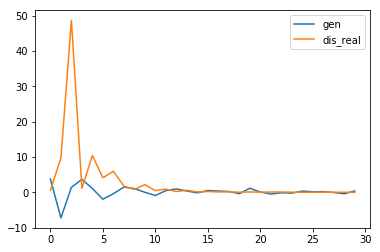

Generation 10  fitness : -13.045525696099944
#################################
population fitness : [ -98.3253243   -23.15358927  -36.47492356  -97.36101602 -112.86507543
 -114.55915656  -93.62267547  -95.13342458  -24.86805828 -101.73724161]
mean fit : -79.8100485085962
[0.1 0.  0.  0.1 0.  0.1 0.  0.1 0.  0. ]
5.203775317942468
Evolving...
Choice : [1, 1, 4, 9, 1, 7, 2, 0, 6, 8, 3]


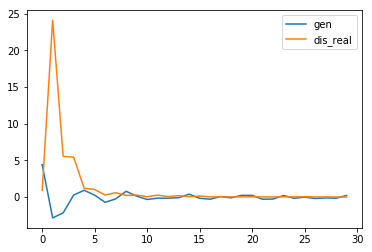

Generation 11  fitness : -23.153589269570567
#################################
population fitness : [ -22.94227126  -23.20611214 -101.45070551 -101.40795564  -55.63177783
  -58.19268223  -32.20370805  -93.47223639  -19.43807685  -23.97256735]
mean fit : -53.191809325040616
[0.1 0.1 0.1 0.1 0.  0.  0.1 0.  0.1 0. ]
5.5452359887769225
Evolving...
Choice : [1, 7, 4, 0, 8, 3, 6, 9, 8, 8, 5]


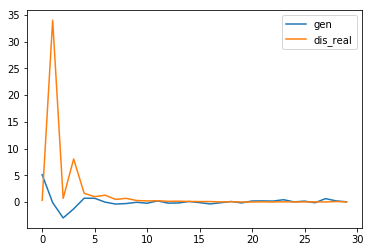

Generation 12  fitness : -19.438076851134323
#################################
population fitness : [ -38.25149907  -49.94309188 -101.86931892  -57.11166676 -103.36599775
  -94.56314457  -95.46329926  -29.49208319  -23.19283842 -112.07044917]
mean fit : -70.53233889986193
[0.1 0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1]
5.263017987155079
Evolving...
Choice : [4, 3, 8, 6, 8, 2, 1, 8, 5, 7, 0]


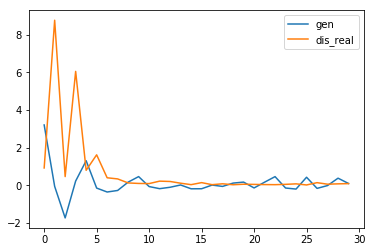

Generation 13  fitness : -23.192838422068956
#################################
population fitness : [-112.45146124  -44.26032404  -24.30962332  -22.30830749 -114.96034
  -95.01411982  -97.41773073 -111.74404173  -94.37813861 -112.1628145 ]
mean fit : -82.9006901485504
[0.1 0.1 0.  0.1 0.  0.  0.1 0.  0.  0.1]
5.159780195730929
Evolving...
Choice : [5, 0, 7, 6, 1, 9, 3, 8, 2, 3, 3]


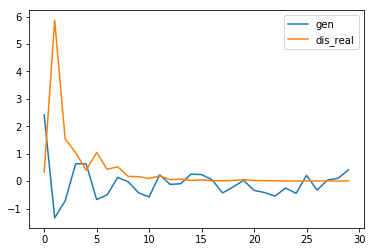

Generation 14  fitness : -22.30830749184788
#################################
population fitness : [ -64.55395831 -110.81744523  -20.8060201   -50.28421468  -54.68296051
 -105.34614028  -35.07491282  -94.49277035  -39.58034784  -94.54460856]
mean fit : -67.01833786800755
[0.1 0.1 0.  0.1 0.  0.  0.1 0.  0.1 0. ]
5.291084299779455
Evolving...
Choice : [9, 2, 0, 3, 6, 2, 4, 2, 7, 8, 5]


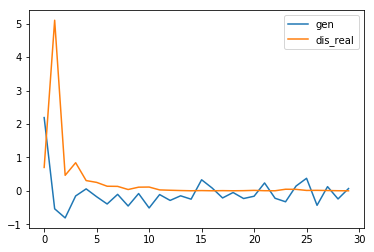

Generation 15  fitness : -20.806020104611818
#################################
population fitness : [ -34.58491256 -116.86513569  -51.53491331  -93.90118164  -30.63142837
 -102.20807549  -45.11654485  -26.22631819 -120.912719    -97.06738657]
mean fit : -71.90486156706957
[0.  0.1 0.  0.1 0.  0.  0.  0.  0.1 0. ]
5.325106342238018
Evolving...
Choice : [6, 9, 5, 2, 7, 4, 7, 3, 7, 0, 1]


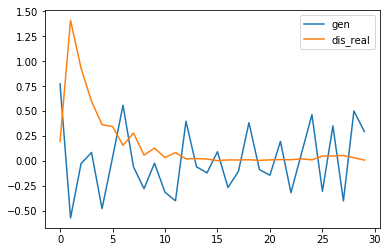

Generation 16  fitness : -26.226318188717805
#################################
population fitness : [-64.67696163 -95.47565399 -12.33021919 -94.89864018 -24.51939326
 -98.33337732 -23.65159679 -93.81656999 -27.42244943 -39.09675468]
mean fit : -57.42216164699314
[0.1 0.1 0.1 0.  0.1 0.1 0.1 0.  0.  0.1]
5.269568539509862
Evolving...
Choice : [9, 4, 2, 1, 2, 2, 6, 8, 3, 0, 7]


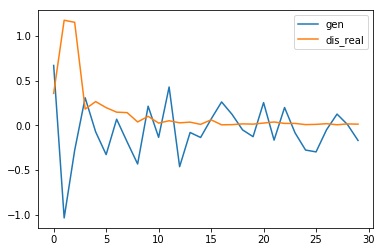

Generation 17  fitness : -12.330219191695312
#################################
population fitness : [ -44.32851892 -110.57893948  -24.4280374   -96.17503234  -13.56204033
 -101.48393213  -29.59504311  -21.89982855  -72.35140595  -25.51379756]
mean fit : -53.99165757786352
[0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1]
5.37136600989067
Evolving...
Choice : [7, 6, 4, 2, 9, 8, 4, 0, 4, 3, 5]


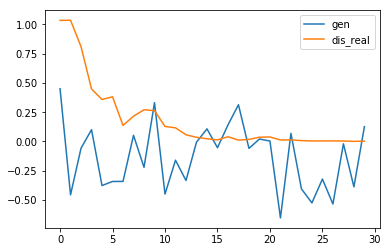

Generation 18  fitness : -13.562040333262399
#################################
population fitness : [ -26.63381256  -26.75994285  -29.29129095  -20.82334724  -47.03418113
 -116.55619343  -25.3169247   -96.92259944 -113.89459936  -28.99737801]
mean fit : -53.2230269675224
[0.  0.  0.1 0.1 0.  0.  0.1 0.1 0.1 0. ]
5.4270433507629114
Evolving...
Choice : [4, 6, 3, 1, 0, 2, 3, 7, 8, 9, 3]


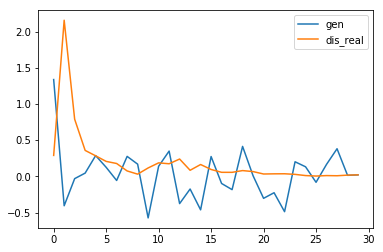

Generation 19  fitness : -20.823347242763663
#################################
population fitness : [ -96.86725248  -43.00165447  -42.00482703  -24.66484024 -101.44452704
  -28.98735675 -110.42082374  -17.68531227  -27.88009584  -93.94862027]
mean fit : -58.690531011860614
[0.  0.1 0.1 0.1 0.  0.  0.1 0.  0.1 0. ]
5.338660140732276
Evolving...
Choice : [1, 0, 7, 4, 8, 9, 7, 3, 5, 2, 7]


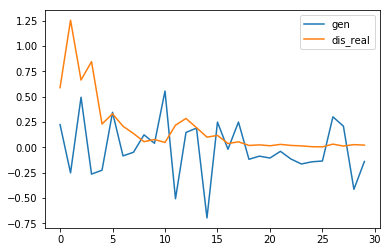

Generation 20  fitness : -17.685312266540897
#################################
population fitness : [-112.37728282  -37.76521645 -112.78223487 -101.48936367 -111.4898446
  -15.30686265  -70.10605906  -38.95336036  -38.82118276  -96.03757727]
mean fit : -73.51289845122636
[0.  0.  0.1 0.  0.  0.  0.  0.1 0.1 0. ]
5.308624008862941
Evolving...
Choice : [1, 5, 3, 5, 6, 8, 5, 7, 0, 9, 4]


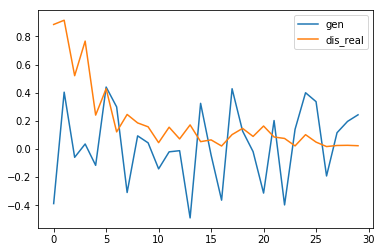

Generation 21  fitness : -15.30686265380854
#################################
population fitness : [ -32.02074139  -33.73601622 -100.52045508  -20.95396529  -60.14745193
  -96.12356674  -94.04365599  -33.98605733  -99.47053783 -120.93931385]
mean fit : -69.19417616542509
[0.  0.  0.1 0.  0.  0.  0.1 0.  0.1 0.1]
5.338002725295647
Evolving...
Choice : [5, 0, 1, 6, 7, 3, 3, 2, 3, 8, 4]


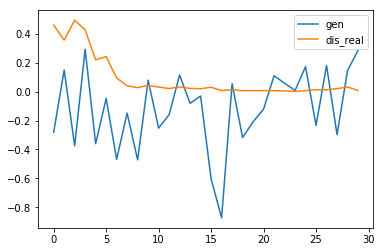

Generation 22  fitness : -20.95396529236722
#################################
population fitness : [-121.66919941  -40.35262376  -95.13439419  -93.78781574  -34.08337742
  -21.0599453   -24.31129983  -27.13985628 -100.02224859 -113.4577951 ]
mean fit : -67.10185556150577
[0.  0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1]
5.352481864601842
Evolving...
Choice : [6, 9, 8, 7, 2, 4, 5, 3, 1, 5, 5]


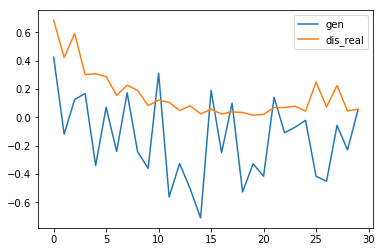

Generation 23  fitness : -21.05994529945725
#################################
population fitness : [ -44.63286972 -101.73833072  -14.18337085 -113.66914206  -47.00758835
  -18.30485274 -131.49622464  -47.13710525  -29.85012809 -126.00385828]
mean fit : -67.40234706907323
[0.  0.1 0.  0.1 0.1 0.  0.1 0.  0.  0.1]
5.409054500284765
Evolving...
Choice : [2, 8, 0, 4, 2, 7, 9, 2, 5, 3, 1]


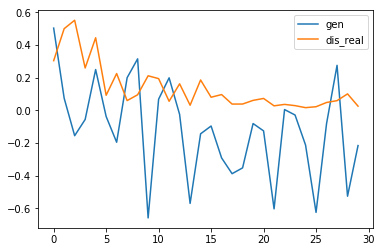

Generation 24  fitness : -14.18337085142007
#################################
population fitness : [ -47.17746153  -25.60414891  -58.67632576  -28.24946221  -20.81317422
  -50.866959   -119.68773688  -37.42177853  -93.68501264  -30.00554335]
mean fit : -51.218760304803915
[0.  0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1]
5.438668447620162
Evolving...
Choice : [1, 5, 0, 2, 7, 4, 3, 9, 4, 4, 8]


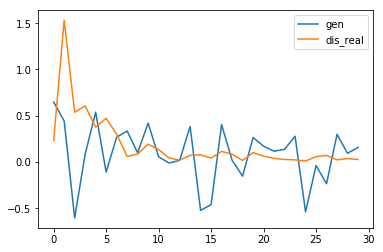

Generation 25  fitness : -20.81317422325978
#################################
population fitness : [ -30.19965831  -33.52589608  -44.78159213  -57.40876269  -52.63587527
  -19.8902155  -120.52556596 -105.0490176   -20.1113783   -28.88194056]
mean fit : -51.30099024013448
[0.1 0.1 0.1 0.1 0.1 0.  0.1 0.  0.1 0.1]
5.441154312302479
Evolving...
Choice : [2, 3, 5, 8, 1, 7, 5, 5, 9, 4, 0]


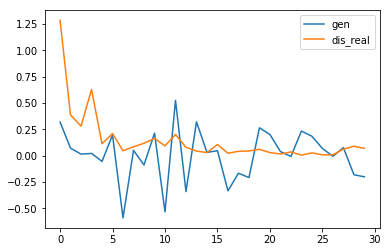

Generation 26  fitness : -19.890215504658944
#################################
population fitness : [-67.4055733  -45.96355202 -29.28320283 -38.45639899 -51.9500109
 -47.60069898 -20.34052099 -94.43477896 -37.70389908 -97.59768939]
mean fit : -53.073632546154194
[0.  0.1 0.  0.1 0.1 0.  0.1 0.1 0.  0.1]
5.316708310930888
Evolving...
Choice : [4, 7, 2, 6, 0, 5, 8, 6, 3, 1, 6]


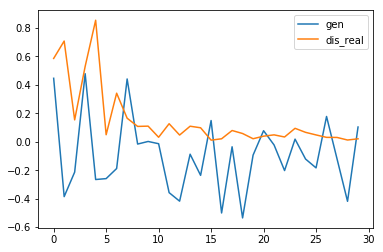

Generation 27  fitness : -20.34052099058329
#################################
population fitness : [-95.11180223 -24.49173293 -48.16921404 -28.71237606 -56.21929835
 -97.87113851 -35.81382044 -47.48974381 -53.99394083 -28.54130772]
mean fit : -51.64143749347638
[0.1 0.  0.  0.  0.1 0.  0.  0.  0.1 0.1]
5.332572690184894
Evolving...
Choice : [1, 2, 9, 0, 7, 4, 3, 1, 8, 6, 1]


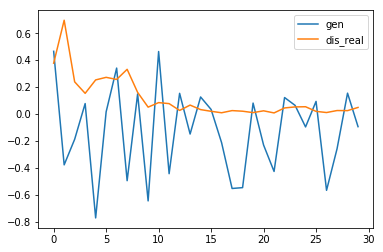

Generation 28  fitness : -24.491732933727928
#################################
population fitness : [ -34.25163863  -26.28353726 -123.56071327  -98.10173027  -49.90445341
 -128.07551584  -15.24843525 -108.62498247  -97.19290958  -36.14319759]
mean fit : -71.73871135710365
[0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0. ]
5.366548353805414
Evolving...
Choice : [6, 2, 6, 3, 0, 7, 6, 1, 9, 4, 8]


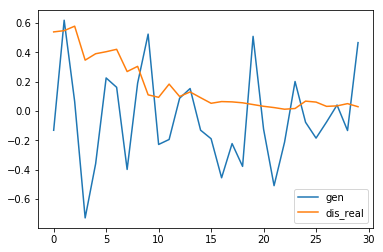

Generation 29  fitness : -15.24843524944244
#################################
population fitness : [-98.7406374  -21.74695613 -38.78023918 -50.89204408 -35.8435734
 -15.56899282 -29.79118204 -97.09827663 -32.86178202 -31.66715848]
mean fit : -45.29908421870634
[0.  0.1 0.  0.  0.  0.1 0.1 0.  0.  0. ]
5.392975560150617
Evolving...
Choice : [7, 1, 5, 2, 3, 5, 8, 6, 9, 4, 5]


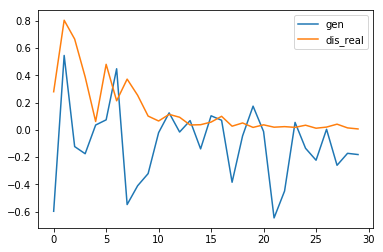

Generation 30  fitness : -15.568992819445771
#################################
population fitness : [ -25.49107973 -128.14194083  -65.01546935  -31.64043737  -42.65948141
 -126.15076564  -70.9940336   -20.2903031   -43.65050351   -8.54163903]
mean fit : -56.25756535681444
[0.  0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0. ]
5.480405219385303
Evolving...
Choice : [6, 9, 5, 8, 0, 2, 9, 7, 3, 9, 4]


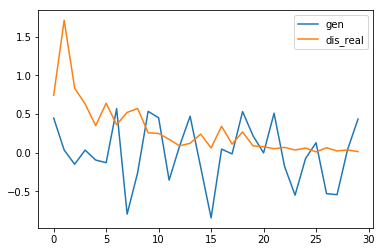

Generation 31  fitness : -8.541639031802564
#################################
population fitness : [-103.35676372  -97.95456359  -51.65013956  -24.72600868  -62.56031132
   -6.99255924  -54.19802584  -43.2836961   -30.41186084  -15.30567108]
mean fit : -49.04395999670983
[0.1 0.1 0.  0.1 0.1 0.1 0.  0.  0.1 0.1]
5.369710445393154
Evolving...
Choice : [6, 2, 8, 3, 4, 5, 7, 1, 5, 9, 5]


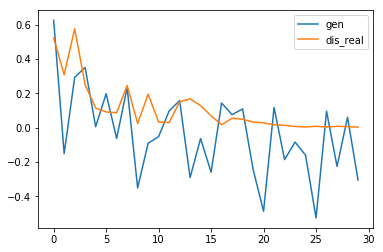

Generation 32  fitness : -6.992559238239761
#################################
population fitness : [ -40.19575015  -24.40505436  -18.81584803  -36.53897175  -45.32500337
  -21.57014228  -42.82749623  -34.91864557   -7.5378999  -110.78426238]
mean fit : -38.29190740269085
[0.1 0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.1]
5.459816475842081
Evolving...
Choice : [5, 7, 8, 1, 3, 8, 8, 4, 6, 2, 0]


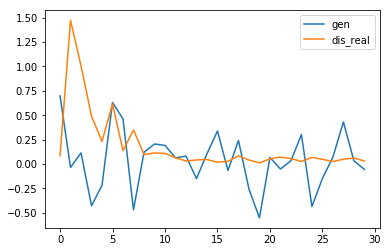

Generation 33  fitness : -7.5378999042983414
#################################
population fitness : [  -8.73961705  -49.01013116  -22.57171992  -96.14676823  -21.95201568
  -38.53715004 -104.01885182 -117.32380281  -30.13007242  -79.86312779]
mean fit : -56.82932569239868
[0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.1]
5.390758571413155
Evolving...
Choice : [1, 0, 6, 0, 2, 5, 3, 0, 4, 8, 9]


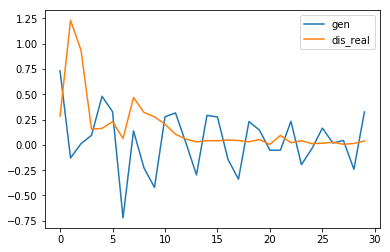

Generation 34  fitness : -8.739617054064148
#################################
population fitness : [ -47.39481826  -13.8864017   -15.42115731  -19.59635644  -96.662984
 -121.15301304  -41.05021214  -28.51724158  -68.18571187  -66.27502198]
mean fit : -51.81429183272992
[0.1 0.  0.1 0.  0.1 0.  0.1 0.  0.1 0.1]
5.439578873872396
Evolving...
Choice : [1, 7, 1, 3, 1, 9, 6, 8, 0, 2, 4]


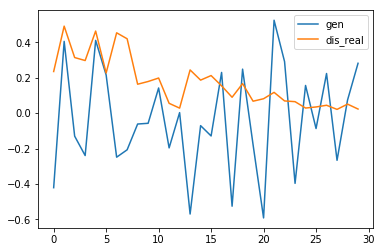

Generation 35  fitness : -13.886401704303704
#################################
population fitness : [-21.07330576 -16.22311668 -22.42016491 -12.47632329 -33.10005305
 -32.50469601 -33.17445522 -15.36944315 -29.71390112 -99.06619927]
mean fit : -31.512165845854874
[0.1 0.1 0.  0.  0.1 0.1 0.1 0.  0.1 0. ]
5.439408316585146
Evolving...
Choice : [3, 0, 8, 6, 7, 3, 5, 3, 2, 4, 1]


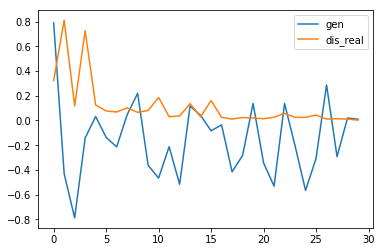

Generation 36  fitness : -12.476323290268748
#################################
population fitness : [ -18.052129    -19.72411133  -66.59666624  -52.85038165  -17.48076062
  -18.54614915  -24.10104175  -21.63984145  -19.44902639 -113.65695817]
mean fit : -37.20970657385202
[0.  0.  0.1 0.1 0.  0.1 0.1 0.  0.  0.1]
5.474316052601123
Evolving...
Choice : [6, 4, 7, 3, 4, 5, 8, 1, 0, 4, 2]


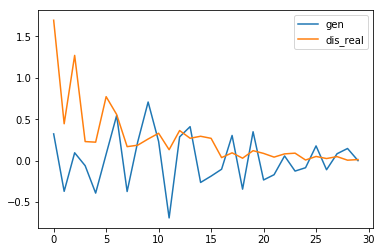

Generation 37  fitness : -17.48076061651902
#################################
population fitness : [ -13.43729682  -32.76513313 -114.64581924  -42.58948648  -36.22176427
 -115.54830848  -21.09889346  -20.03205039  -21.39829412  -23.00759119]
mean fit : -44.07446375853347
[0.  0.1 0.1 0.  0.1 0.1 0.1 0.  0.1 0.1]
5.5107537839009
Evolving...
Choice : [1, 0, 6, 2, 0, 3, 0, 4, 8, 7, 9]


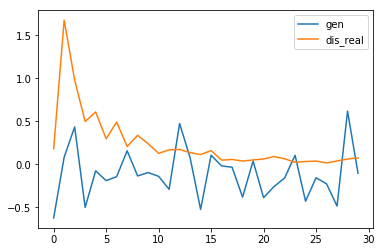

Generation 38  fitness : -13.437296819878506
#################################
population fitness : [ -97.46014862  -43.00551423 -104.23978568  -11.63571308  -23.19206132
  -30.00835073  -50.71568403  -35.92723428  -15.07356401 -102.11013135]
mean fit : -51.336818733423044
[0.1 0.  0.1 0.1 0.  0.  0.1 0.1 0.1 0. ]
5.371750834347627
Evolving...
Choice : [3, 7, 8, 4, 1, 9, 3, 3, 6, 0, 5]


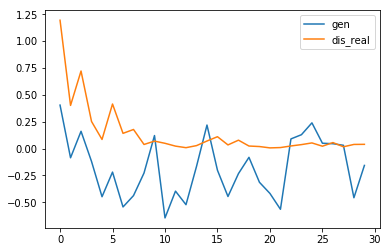

Generation 39  fitness : -11.635713078422718
#################################
population fitness : [ -59.64504046  -69.10830804  -20.89103045  -34.36564511  -76.03810214
 -117.08934184  -30.48636944  -21.90701009 -100.4633172   -98.384284  ]
mean fit : -62.837844878033664
[0.  0.1 0.  0.  0.1 0.  0.1 0.1 0.1 0. ]
5.357846445897907
Evolving...
Choice : [2, 3, 8, 2, 2, 6, 1, 7, 4, 9, 0]


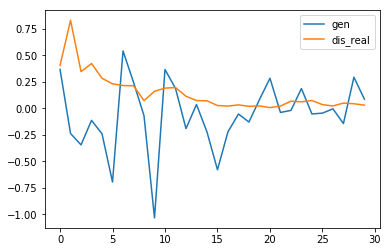

Generation 40  fitness : -20.891030450746154
#################################
population fitness : [-102.1531453   -33.49999524  -29.02977175  -22.93947832  -32.58412998
  -40.2401128   -52.63414424 -123.43567568  -18.14576107  -32.82034187]
mean fit : -48.74825562448047
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1]
5.464846965343174
Evolving...
Choice : [8, 6, 2, 9, 1, 4, 8, 8, 5, 3, 0]


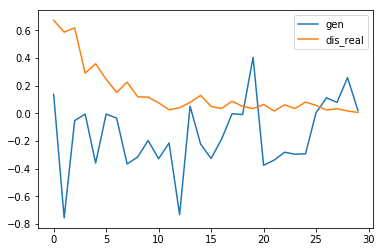

Generation 41  fitness : -18.14576107277222
#################################
population fitness : [ -46.72122564  -45.10747087  -19.70938303 -100.44016974  -48.58770237
 -111.58071656  -26.28950034 -103.88589932  -94.65207687 -113.7432683 ]
mean fit : -71.07174130382215
[0.  0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0. ]
5.280372696655427
Evolving...
Choice : [2, 2, 2, 8, 3, 6, 0, 4, 5, 1, 7]


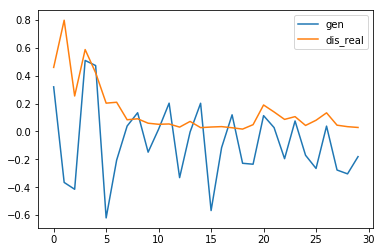

Generation 42  fitness : -19.70938302667134
#################################
population fitness : [ -19.1537479   -19.43176841  -72.0642061  -112.95439862 -100.53579387
  -20.96549387 -122.58197211  -26.95365703 -115.80935086  -34.48961615]
mean fit : -64.49400049202437
[0.  0.  0.1 0.  0.  0.1 0.1 0.  0.  0. ]
5.371878434308282
Evolving...
Choice : [0, 0, 2, 0, 7, 1, 3, 5, 9, 4, 8]


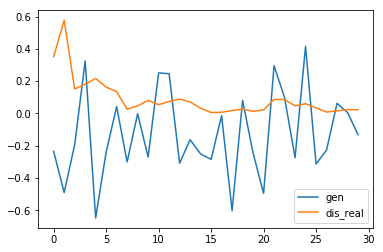

Generation 43  fitness : -19.153747902737575
#################################
population fitness : [ -19.15823774  -39.71180349  -53.46481064  -41.79897275  -41.04901727
  -99.45336007 -100.24601656 -102.50448797  -48.97816356  -29.23920295]
mean fit : -57.56040729985152
[0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.1 0. ]
5.325381695867914
Evolving...
Choice : [4, 0, 9, 0, 1, 8, 3, 5, 2, 0, 6]


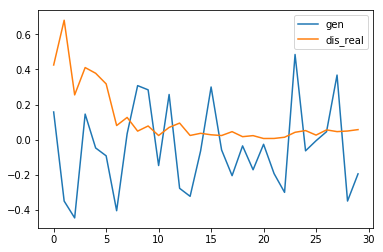

Generation 44  fitness : -19.15823773803261
#################################
population fitness : [-55.6748827  -23.58994105 -57.36779875 -47.79181149 -41.23456923
 -25.57491439 -99.51780528 -69.40570361 -31.05790272 -45.44521386]
mean fit : -49.666054307630944
[0.  0.1 0.  0.  0.1 0.  0.1 0.  0.  0. ]
5.344348837210565
Evolving...
Choice : [0, 2, 9, 4, 7, 3, 5, 8, 1, 1, 1]


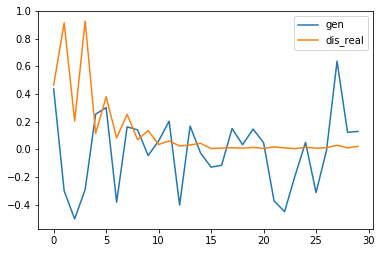

Generation 45  fitness : -23.589941049660293
#################################
population fitness : [ -61.26567982  -27.38507116  -30.64449888  -49.72379913  -64.59761739
  -21.32230985  -64.80237313  -38.3596128  -118.60209028  -70.46878928]
mean fit : -54.71718417428521
[0.1 0.1 0.1 0.1 0.  0.1 0.1 0.  0.  0.1]
5.419265543778044
Evolving...
Choice : [3, 4, 6, 0, 2, 5, 5, 7, 5, 1, 9]


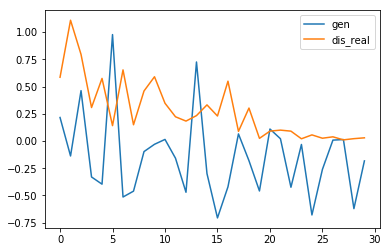

Generation 46  fitness : -21.322309852949445
#################################
population fitness : [-78.13749112 -38.56492116 -81.94292364 -40.26707667 -95.77550719
 -27.41777028 -27.22440906 -97.83677273 -29.12634955 -30.2329605 ]
mean fit : -54.65261819080534
[0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0. ]
5.304717348985134
Evolving...
Choice : [1, 4, 2, 3, 8, 6, 0, 5, 6, 9, 6]


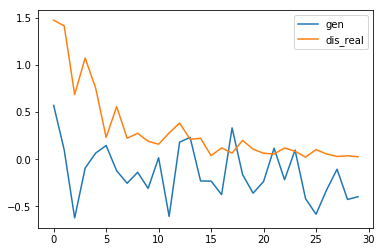

Generation 47  fitness : -27.22440906472321
#################################
population fitness : [ -26.78182017  -95.05360046  -48.24257805  -87.11739274  -61.58793902
  -62.70418283 -102.64479749  -38.21210866  -42.97213076  -63.13733728]
mean fit : -62.845388745671414
[0.1 0.  0.1 0.  0.1 0.1 0.  0.1 0.1 0. ]
5.268320129576451
Evolving...
Choice : [4, 3, 1, 0, 7, 9, 0, 0, 8, 5, 2]


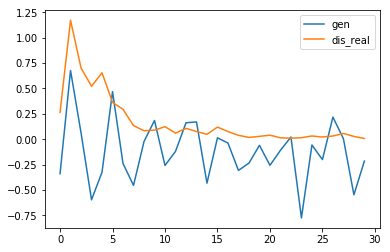

Generation 48  fitness : -26.78182017382726
#################################
population fitness : [ -43.36687152  -65.18489275  -94.86549935  -64.17856255  -48.75581442
  -52.90389098  -59.58999863 -125.51011547  -60.866635    -50.59283278]
mean fit : -66.58151134660395
[0.  0.1 0.  0.  0.  0.  0.1 0.  0.  0. ]
5.395871950001934
Evolving...
Choice : [5, 2, 3, 4, 0, 1, 0, 9, 6, 0, 8]


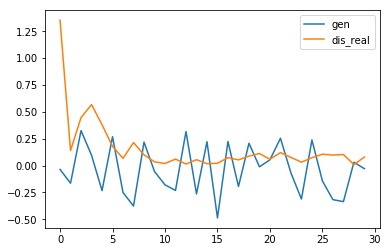

Generation 49  fitness : -43.36687152380098
#################################
population fitness : [-101.27474239  -40.31953232  -37.83817406  -40.16458808  -30.03315752
  -87.01593979  -43.31802049  -26.54858135  -45.98788839  -31.75836617]
mean fit : -48.4258990563021
[0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.1]
5.361556726942974
Evolving...
Choice : [8, 7, 3, 4, 5, 6, 1, 7, 9, 7, 2]


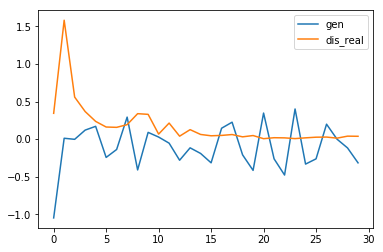

Generation 50  fitness : -26.548581345866204
#################################
population fitness : [ -75.90305289 -119.12171054 -106.67577395  -61.31913932  -81.17687066
  -49.79089348  -95.91085402  -31.36586075  -50.02135257  -75.08396106]
mean fit : -74.63694692398906
[0.  0.  0.  0.  0.1 0.1 0.1 0.  0.  0.1]
5.3015131114837715
Evolving...
Choice : [7, 2, 4, 7, 7, 9, 3, 5, 8, 6, 0]


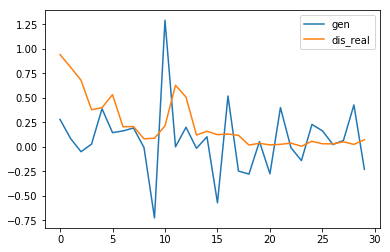

Generation 51  fitness : -31.365860749279403
#################################
population fitness : [ -44.6408251   -95.9811885  -117.28742202  -42.44283798  -57.49952435
 -108.6024637   -52.97576274 -102.59104191  -41.76058633  -28.06100467]
mean fit : -69.18426573046966
[0.  0.  0.  0.1 0.  0.1 0.1 0.  0.1 0. ]
5.319706462928472
Evolving...
Choice : [9, 5, 3, 7, 9, 6, 1, 0, 8, 9, 4]


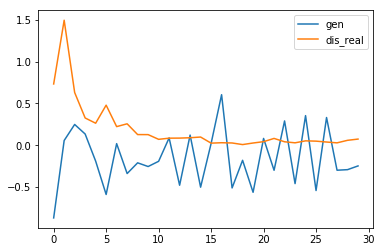

Generation 52  fitness : -28.06100466732132
#################################
population fitness : [-99.04501369 -56.52650884 -22.7810198  -44.8493205  -26.23114964
 -96.33887643 -29.65176226 -67.18752858 -51.73351483 -94.1629286 ]
mean fit : -58.850762316614144
[0.1 0.1 0.  0.  0.1 0.1 0.1 0.1 0.1 0. ]
5.277589058166058
Evolving...
Choice : [9, 2, 3, 4, 1, 7, 5, 8, 6, 2, 2]


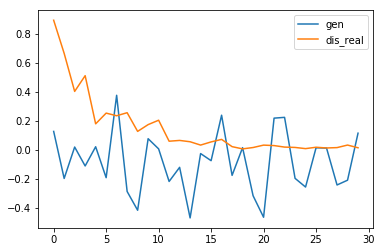

Generation 53  fitness : -22.7810197970974
#################################
population fitness : [ -98.87135739  -42.0710397   -51.30209032 -128.55007326  -76.81511988
  -61.20042165  -76.445917    -51.06270877  -92.54711353  -22.91637262]
mean fit : -70.17822141171266
[0.1 0.1 0.  0.1 0.1 0.  0.1 0.1 0.  0. ]
5.387617752018583
Evolving...
Choice : [6, 9, 5, 8, 0, 9, 1, 4, 9, 7, 2]


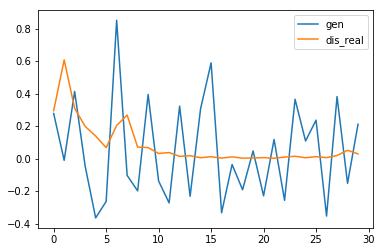

Generation 54  fitness : -22.916372623427595
#################################
population fitness : [ -54.93671191  -74.32737237  -31.07736392  -98.44732815 -101.66285974
  -72.22954218  -69.68274656  -19.95068539  -77.48293694  -95.3671044 ]
mean fit : -69.51646515441409
[0.1 0.1 0.1 0.  0.1 0.1 0.1 0.  0.  0.1]
5.194511500612452
Evolving...
Choice : [0, 3, 7, 6, 7, 7, 5, 8, 1, 9, 2]


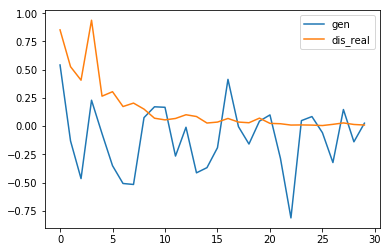

Generation 55  fitness : -19.95068539028986
#################################
population fitness : [ -83.43611759  -37.51563689  -33.67367105  -59.05644069  -19.43999402
  -40.27192438  -84.97368032  -96.43015345 -133.58091596 -101.93291371]
mean fit : -69.03114480645942
[0.  0.1 0.  0.1 0.1 0.1 0.  0.1 0.  0. ]
5.415240441150962
Evolving...
Choice : [2, 4, 4, 3, 5, 0, 7, 1, 4, 9, 6]


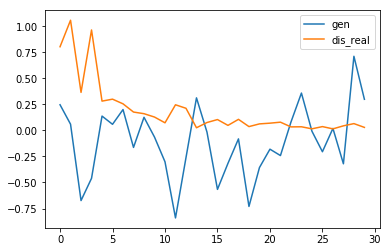

Generation 56  fitness : -19.439994020332367
#################################
population fitness : [ -32.66088024  -60.11994505  -33.49551298  -11.53121658  -73.74927996
 -104.47841872  -29.39580515  -43.64447901  -57.76686712  -23.80197182]
mean fit : -47.06443766267482
[0.1 0.  0.1 0.  0.  0.  0.1 0.1 0.1 0. ]
5.385436930727055
Evolving...
Choice : [7, 4, 3, 9, 8, 1, 3, 0, 2, 6, 3]


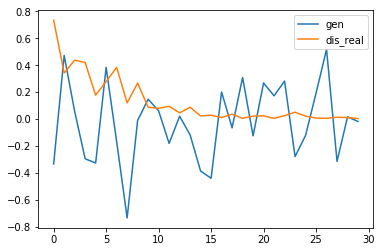

Generation 57  fitness : -11.53121658308304
#################################
population fitness : [ -47.66611387 -112.10134099  -83.07603598  -57.69546622 -118.18760933
 -111.36265328  -52.78923844  -25.3512113   -60.13708104 -106.94686   ]
mean fit : -77.5313610458276
[0.  0.1 0.  0.  0.  0.1 0.1 0.1 0.  0. ]
5.261272806478588
Evolving...
Choice : [8, 5, 2, 1, 7, 7, 6, 9, 3, 0, 7]


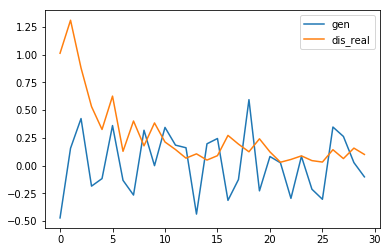

Generation 58  fitness : -25.35121129845784
#################################
population fitness : [ -35.42576415  -54.38672588  -36.68218189  -32.96021882 -112.96938994
  -48.19900248  -32.53577882  -60.67161867  -27.26288772 -120.38973203]
mean fit : -56.14833004035228
[0.  0.  0.1 0.1 0.  0.  0.  0.  0.1 0. ]
5.422536195187805
Evolving...
Choice : [8, 4, 1, 7, 3, 2, 8, 8, 5, 0, 6]


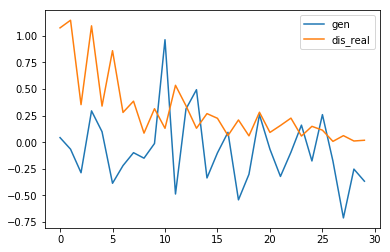

Generation 59  fitness : -27.262887718115742
#################################
population fitness : [-101.69242066  -50.12465142  -40.57824563 -124.2101042  -124.07490174
  -94.8766926   -52.93045693  -27.0765078   -97.84953609  -43.96669189]
mean fit : -75.73802089615864
[0.  0.1 0.1 0.  0.1 0.1 0.1 0.  0.  0. ]
5.457908384192113
Evolving...
Choice : [4, 7, 9, 0, 6, 7, 8, 5, 2, 7, 1]


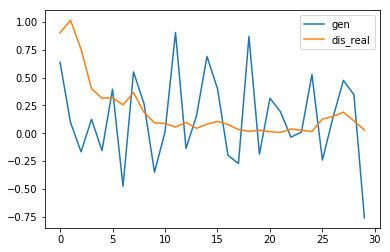

Generation 60  fitness : -27.076507804240027
#################################
population fitness : [ -59.51142639 -119.3684639  -105.30794426  -60.84200164  -38.52474907
 -100.96196144 -101.77953363  -51.84278993  -44.6120181   -31.0402002 ]
mean fit : -71.3791088562251
[0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.  0.1]
5.318987909447302
Evolving...
Choice : [0, 9, 9, 2, 8, 4, 5, 9, 6, 3, 7]


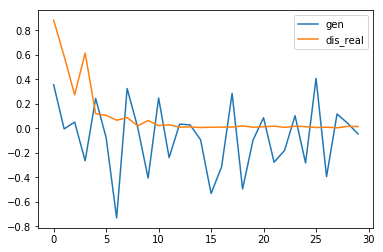

Generation 61  fitness : -31.040200202617754
#################################
population fitness : [ -38.99213921  -43.1129249  -103.88420182  -78.94381698  -39.78939381
 -128.12100084  -39.28808464  -60.88571534 -105.01215459  -68.69957523]
mean fit : -70.67290073521475
[0.  0.1 0.1 0.  0.1 0.  0.1 0.  0.  0.1]
5.380396031943742
Evolving...
Choice : [0, 0, 0, 3, 6, 7, 8, 2, 1, 4, 9]


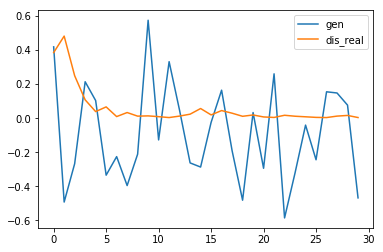

Generation 62  fitness : -38.99213920621201
#################################
population fitness : [ -39.06052617  -38.72413632  -59.7917945   -49.09942612 -114.50695544
  -49.01814596 -101.6190938   -77.1758376  -101.44060724  -76.70574187]
mean fit : -70.71422650111268
[0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.  0.1]
5.295064189522394
Evolving...
Choice : [0, 1, 3, 6, 1, 2, 9, 7, 1, 5, 8]


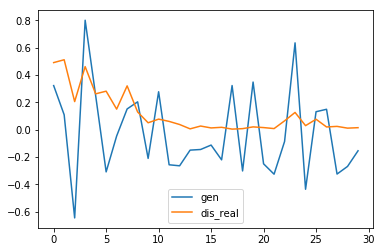

Generation 63  fitness : -38.724136318089414
#################################
population fitness : [ -64.43265998  -86.92142006  -29.77843734  -45.70043001  -61.25514268
  -40.95927094  -80.95833064  -62.51217925 -103.09834584 -105.25373776]
mean fit : -68.08699545093563
[0.1 0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0. ]
5.258654994795269
Evolving...
Choice : [4, 8, 0, 2, 6, 1, 5, 2, 2, 3, 7]


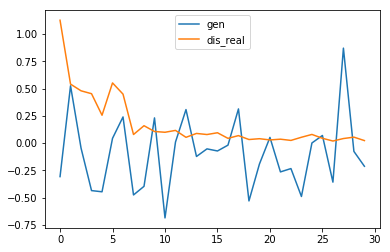

Generation 64  fitness : -29.778437343514867
#################################
population fitness : [-131.69479437 -112.9648696  -121.61324054  -88.96141865 -120.08579538
  -37.68301799  -58.51303423  -52.76849709  -53.73852273  -48.21708307]
mean fit : -82.62402736582169
[0.1 0.1 0.  0.1 0.  0.1 0.  0.  0.1 0.1]
5.320976938947511
Evolving...
Choice : [3, 5, 4, 8, 2, 5, 9, 5, 1, 7, 6]


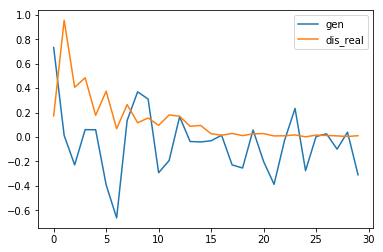

Generation 65  fitness : -37.683017994074085
#################################
population fitness : [-62.82123095 -90.91492976 -41.89131568 -55.262452   -46.46414582
 -50.45226556 -86.37420321 -60.50138058 -28.84885086 -48.68115729]
mean fit : -57.221193171719804
[0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.1 0. ]
5.226377729924089
Evolving...
Choice : [4, 3, 7, 5, 8, 6, 8, 2, 9, 8, 0]


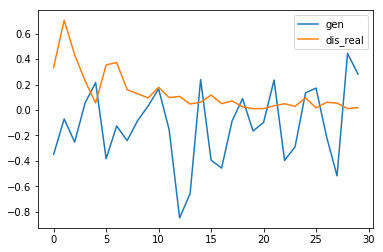

Generation 66  fitness : -28.848850860797455
#################################
population fitness : [-115.77828651  -62.5769342   -68.21703665  -62.48106295  -72.98172688
  -93.9389909  -114.4306763   -85.54432052  -46.39507084 -101.49934356]
mean fit : -82.38434493202006
[0.1 0.1 0.1 0.  0.1 0.1 0.  0.  0.  0. ]
5.233658889533388
Evolving...
Choice : [6, 2, 9, 8, 4, 7, 1, 5, 8, 3, 8]


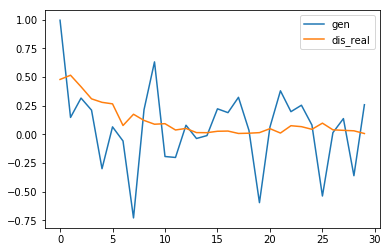

Generation 67  fitness : -46.39507083911569
#################################
population fitness : [ -31.54383225  -31.82119207  -57.59771019 -113.02372492  -67.41039806
  -54.24784645  -88.08779279  -41.50191812  -53.78708178  -95.30095548]
mean fit : -63.43224521013714
[0.  0.1 0.  0.  0.1 0.1 0.1 0.1 0.  0. ]
5.337265480629932
Evolving...
Choice : [7, 9, 0, 8, 4, 6, 5, 2, 0, 0, 1]


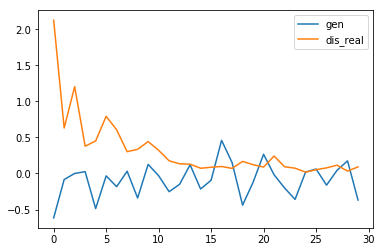

Generation 68  fitness : -31.543832254315326
#################################
population fitness : [ -47.84771258  -40.35231997  -87.93661166  -60.76503436  -70.35854371
  -65.48558089 -103.76302357  -45.13532279  -38.10765466  -74.70868594]
mean fit : -63.4460490137177
[0.1 0.  0.1 0.1 0.1 0.1 0.  0.1 0.1 0. ]
5.2766972305883275
Evolving...
Choice : [4, 5, 2, 8, 3, 8, 8, 0, 9, 7, 1]


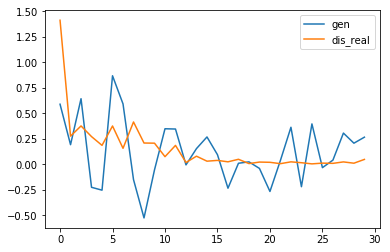

Generation 69  fitness : -38.107654662799064
#################################
population fitness : [ -74.98611129  -54.84298887  -20.07460484  -61.01983825  -93.83149954
  -74.19026833  -49.59000103 -102.1111246   -60.93882867  -36.38824066]
mean fit : -62.797350608397366
[0.  0.1 0.  0.  0.  0.  0.  0.  0.1 0. ]
5.265041088477856
Evolving...
Choice : [3, 9, 1, 2, 8, 4, 2, 5, 0, 2, 6]


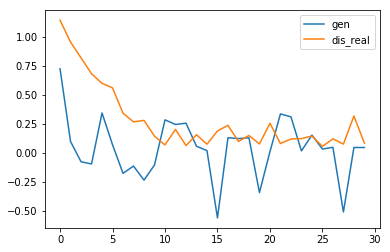

Generation 70  fitness : -20.074604837128753
#################################
population fitness : [ -31.23473868  -76.74885585  -41.41126781  -38.21998627  -49.64288504
  -69.08362145 -109.89780677  -89.05240166  -36.97940276  -48.76192907]
mean fit : -59.10328953586587
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0. ]
5.346794602664689
Evolving...
Choice : [5, 1, 8, 0, 0, 9, 0, 4, 2, 7, 3]


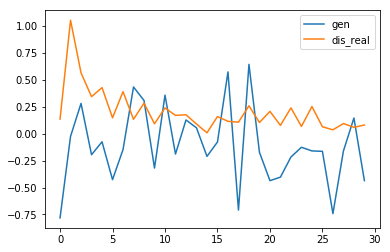

Generation 71  fitness : -31.234738680977202
#################################
population fitness : [-110.98131612  -41.08551217  -40.41111503  -25.07729938  -72.61121219
 -107.80378334  -71.09518743  -56.93763626  -49.6086971  -123.2383882 ]
mean fit : -69.88501472264849
[0.1 0.  0.  0.  0.1 0.  0.1 0.1 0.1 0. ]
5.354782085134264
Evolving...
Choice : [5, 6, 1, 8, 0, 2, 3, 3, 3, 4, 7]


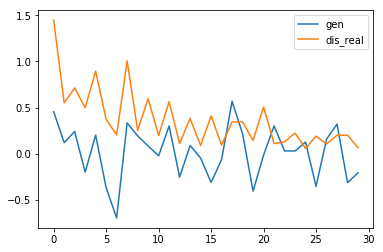

Generation 72  fitness : -25.077299384851138
#################################
population fitness : [-107.42877006  -29.25960165  -78.87420041 -115.28807669  -56.56401669
  -38.43885174  -15.23771775  -28.0293451   -48.16276467  -58.25424757]
mean fit : -57.55375923304143
[0.1 0.  0.  0.1 0.1 0.  0.  0.  0.1 0. ]
5.385169385934828
Evolving...
Choice : [6, 6, 5, 8, 9, 7, 1, 4, 6, 0, 2]


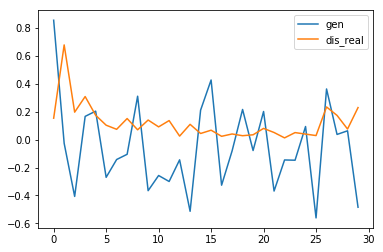

Generation 73  fitness : -15.2377177522685
#################################
population fitness : [ -10.28149121  -47.8381989  -121.69445191  -66.26738838 -109.81173402
  -26.03967762  -34.260861    -46.95140011  -64.21792867  -86.34275761]
mean fit : -61.370588943935935
[0.1 0.1 0.  0.  0.1 0.1 0.  0.1 0.1 0.1]
5.394909423788554
Evolving...
Choice : [0, 9, 0, 7, 3, 1, 8, 0, 5, 6, 4]


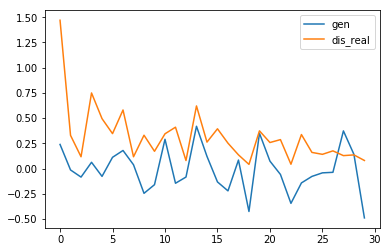

Generation 74  fitness : -10.281491213016048
#################################
population fitness : [ -99.87586664  -35.09452981  -34.54591564  -85.36316009 -109.09738565
  -77.47866842 -105.45003653  -51.76739417  -25.51103932  -57.17079577]
mean fit : -68.13547920439336
[0.  0.1 0.  0.1 0.  0.  0.  0.1 0.1 0.1]
5.272501721365393
Evolving...
Choice : [1, 0, 9, 8, 3, 8, 2, 5, 6, 7, 8]


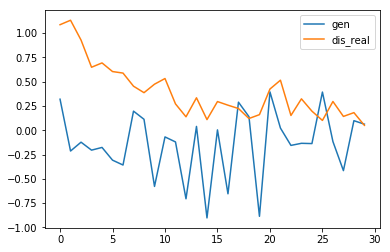

Generation 75  fitness : -25.5110393236272
#################################
population fitness : [-125.53350121  -39.2212799   -31.89934468 -119.12696268  -34.17272893
  -81.17950987  -34.07327251 -120.29924837  -65.01353682  -44.87155869]
mean fit : -69.53909436667371
[0.1 0.1 0.1 0.  0.1 0.1 0.1 0.  0.  0.1]
5.37365499127812
Evolving...
Choice : [5, 4, 9, 6, 3, 8, 1, 2, 2, 7, 2]


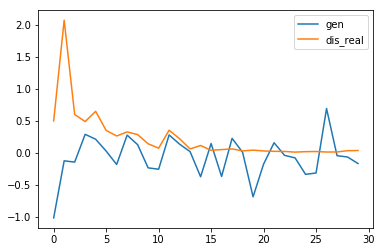

Generation 76  fitness : -31.89934468161587
#################################
population fitness : [-36.37319429 -27.58312073 -34.29367902 -41.61985627 -83.63534378
 -39.71781155 -37.35742124 -29.90933759 -47.65328513 -52.61962266]
mean fit : -43.07626722554165
[0.  0.  0.1 0.1 0.1 0.  0.1 0.  0.1 0.1]
5.2852419526279775
Evolving...
Choice : [5, 9, 2, 1, 7, 0, 3, 1, 1, 6, 8]


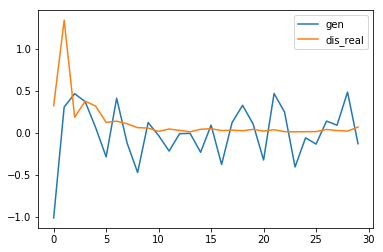

Generation 77  fitness : -27.58312072998518
#################################
population fitness : [ -24.1640898   -44.7356898   -38.62429647  -36.55353658 -114.47528206
  -60.84346552 -113.02170406  -31.00741393  -47.59207307 -122.40803203]
mean fit : -63.34255833150528
[0.1 0.1 0.1 0.  0.1 0.  0.  0.  0.  0. ]
5.388451051251202
Evolving...
Choice : [8, 7, 0, 6, 1, 0, 0, 5, 4, 3, 2]


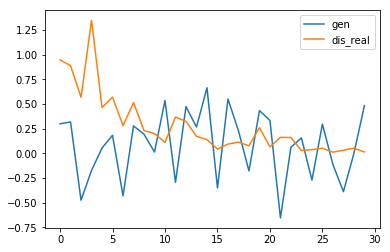

Generation 78  fitness : -24.164089797336132
#################################
population fitness : [ -60.57052707  -63.43036416  -49.01575247  -43.6456405   -28.74399037
  -50.29029904  -19.46815216 -106.80462427  -23.00083668  -56.74676108]
mean fit : -50.17169477981424
[0.  0.  0.1 0.  0.1 0.  0.  0.1 0.1 0. ]
5.383250615479579
Evolving...
Choice : [3, 6, 4, 6, 0, 5, 2, 1, 9, 8, 6]


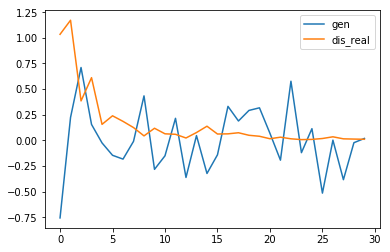

Generation 79  fitness : -19.468152157686642
#################################
population fitness : [-110.80842002  -42.26014607 -122.8177176  -127.63370346  -38.1686508
  -31.86956103  -72.19705374  -37.51939071  -38.09678789  -48.76632682]
mean fit : -67.01377581432806
[0.1 0.  0.  0.1 0.1 0.1 0.  0.1 0.  0.1]
5.400871050874716
Evolving...
Choice : [1, 0, 2, 9, 4, 5, 7, 5, 6, 8, 5]


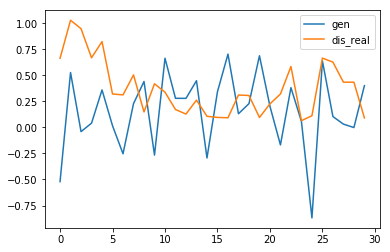

Generation 80  fitness : -31.869561032285954
#################################
population fitness : [ -45.10426548  -35.34204917  -44.04067209  -31.34064832  -37.35214054
 -112.2886047   -33.25309568  -39.77314182  -29.67174705  -33.33582158]
mean fit : -44.150218640952936
[0.  0.1 0.1 0.  0.1 0.1 0.  0.  0.  0. ]
5.442411036003278
Evolving...
Choice : [1, 8, 4, 2, 8, 6, 9, 0, 7, 3, 8]


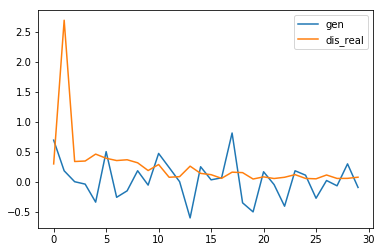

Generation 81  fitness : -29.671747045020947
#################################
population fitness : [-107.97250059  -35.13170842  -29.44731833 -111.7798446   -43.92723711
  -57.98450678  -95.74107586 -119.09996848  -28.74667675  -29.82220494]
mean fit : -65.96530418640225
[0.1 0.  0.  0.  0.1 0.  0.  0.  0.1 0.1]
5.348658381754016
Evolving...
Choice : [8, 5, 3, 9, 1, 8, 6, 8, 2, 4, 0]


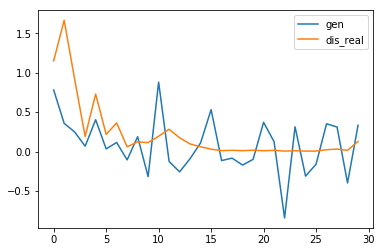

Generation 82  fitness : -28.746676748433487
#################################
population fitness : [ -48.66138193 -114.7994583  -110.04654262 -117.61630383 -149.54067792
 -109.37849925  -58.39615538  -35.55587796  -47.3924407  -106.94406591]
mean fit : -89.83314037971213
[0.1 0.  0.  0.  0.1 0.  0.  0.1 0.1 0.1]
5.386596040374033
Evolving...
Choice : [7, 9, 0, 2, 1, 3, 6, 7, 8, 7, 5]


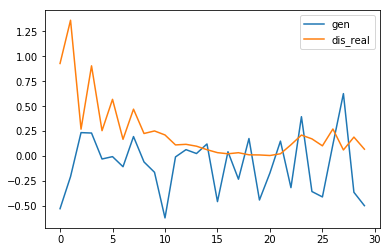

Generation 83  fitness : -35.55587795908993
#################################
population fitness : [-119.12730229 -120.29099348  -51.86064095 -110.38813561  -48.32789433
  -39.56287461 -112.64738836  -49.45431614  -28.68104937  -80.573128  ]
mean fit : -76.09137231462964
[0.  0.  0.  0.  0.  0.1 0.  0.1 0.  0.1]
5.312009728807896
Evolving...
Choice : [5, 9, 2, 8, 0, 8, 8, 4, 6, 3, 7]


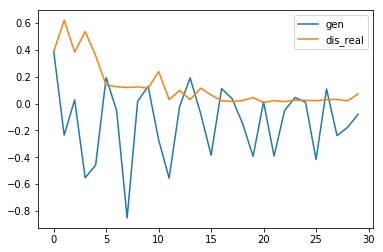

Generation 84  fitness : -28.681049374452385
#################################
population fitness : [-108.73741598 -119.77352908  -50.1183107   -19.89285943  -35.01855976
  -29.02360599  -62.24493392  -77.23299633  -61.44109678 -128.72568899]
mean fit : -69.22089969662265
[0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0. ]
5.388091127270374
Evolving...
Choice : [6, 3, 2, 3, 1, 5, 3, 0, 4, 8, 7]


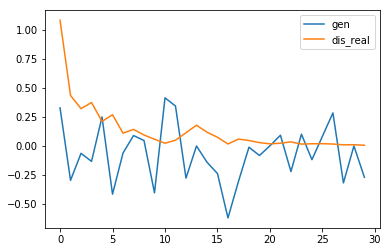

Generation 85  fitness : -19.89285943142522
#################################
population fitness : [-104.88957687  -22.93297658 -125.14631353  -26.99832264  -42.98818155
 -104.33276188  -54.07229047 -113.48073181  -73.00659707 -117.74754364]
mean fit : -78.55952960316917
[0.1 0.  0.  0.1 0.  0.  0.1 0.1 0.1 0.1]
5.296663312194597
Evolving...
Choice : [9, 7, 5, 4, 1, 6, 0, 1, 1, 3, 8]


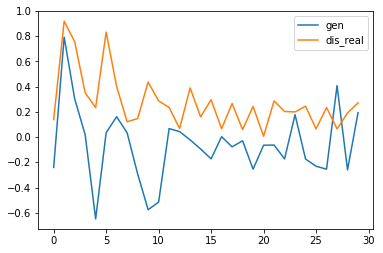

Generation 86  fitness : -22.932976576324528
#################################
population fitness : [-128.76600432 -108.81149502  -26.91363991  -41.15395155  -36.08033668
 -108.12846753  -35.67132666  -17.5928996   -31.52531272  -76.73929089]
mean fit : -61.13827248640691
[0.  0.1 0.1 0.1 0.  0.1 0.  0.  0.  0. ]
5.426681742817075
Evolving...
Choice : [7, 7, 7, 8, 3, 2, 1, 5, 4, 6, 9]


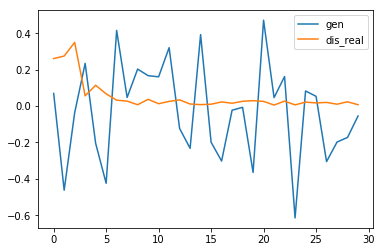

Generation 87  fitness : -17.5928995973741
#################################
population fitness : [ -17.66498131  -21.54229803  -17.6297358   -34.13888136  -63.21730085
 -104.56358351 -116.12776244  -50.34312475  -31.48724596  -41.77202298]
mean fit : -49.84869369934312
[0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1]
5.427913774806296
Evolving...
Choice : [1, 4, 9, 7, 2, 8, 5, 2, 2, 0, 3]


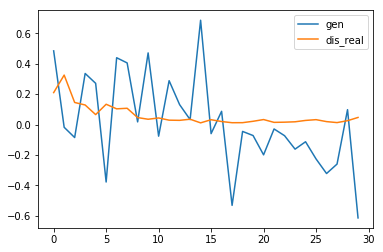

Generation 88  fitness : -17.629735799301415
#################################
population fitness : [ -30.38611898 -108.96579515  -41.72040109 -119.45726133  -58.67564506
  -62.04648803 -103.82889618  -54.28730519  -42.65205283 -104.55992524]
mean fit : -72.65798890717721
[0.  0.1 0.1 0.1 0.1 0.  0.1 0.  0.1 0.1]
5.309254967400887
Evolving...
Choice : [4, 6, 9, 0, 8, 0, 2, 1, 5, 7, 0]


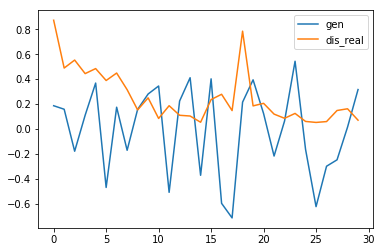

Generation 89  fitness : -30.386118978681626
#################################
population fitness : [-123.20501753  -95.97455417  -41.68505353  -34.78497972  -57.10939625
  -32.7397342   -50.58479692 -116.95985668  -40.55445215  -52.06219916]
mean fit : -64.56600403155576
[0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.  0.1]
5.391610658851733
Evolving...
Choice : [5, 5, 6, 4, 3, 2, 8, 5, 1, 7, 9]


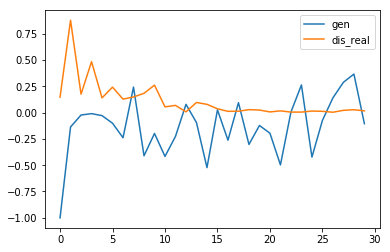

Generation 90  fitness : -32.73973420299727
#################################
population fitness : [ -61.30087342  -74.57649427  -63.2250708   -67.10260963  -39.11091085
  -19.95058323  -60.01503326  -42.14695255 -134.99476303  -74.43310306]
mean fit : -63.68563940935137
[0.  0.1 0.  0.1 0.1 0.1 0.1 0.  0.  0. ]
5.453270280998217
Evolving...
Choice : [5, 0, 6, 4, 5, 5, 3, 1, 7, 2, 9]


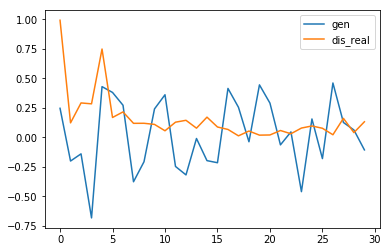

Generation 91  fitness : -19.950583228869977
#################################
population fitness : [ -58.42122294  -70.55029739 -105.55324905 -107.42268972  -62.19228947
  -70.36752221  -72.20791278  -74.78255371  -35.47367341  -48.25536279]
mean fit : -70.52267734768833
[0.1 0.  0.  0.1 0.1 0.  0.1 0.1 0.  0.1]
5.2668574530844765
Evolving...
Choice : [5, 8, 0, 6, 9, 2, 8, 8, 1, 7, 4]


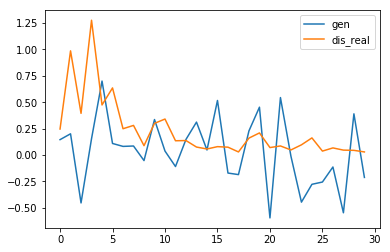

Generation 92  fitness : -35.4736734085576
#################################
population fitness : [ -32.12551198 -118.36813626 -106.27633414  -28.9819308   -52.1971289
  -65.04342875  -37.89148171 -108.28198692  -50.52063083  -34.77786345]
mean fit : -63.44644337161175
[0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.  0.1]
5.3647799225103725
Evolving...
Choice : [5, 4, 2, 3, 0, 3, 6, 9, 8, 3, 7]


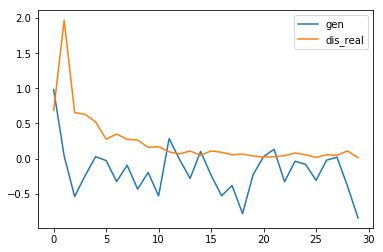

Generation 93  fitness : -28.98193079789416
#################################
population fitness : [-108.97624484 -122.50455068 -117.38758071  -25.86682689 -108.19604254
  -53.35697502  -76.1443995   -66.44041297 -119.7060952   -83.47694831]
mean fit : -88.20560766698527
[0.  0.  0.1 0.1 0.  0.  0.  0.  0.1 0.1]
5.203707798889821
Evolving...
Choice : [6, 3, 5, 9, 3, 7, 2, 8, 4, 3, 0]


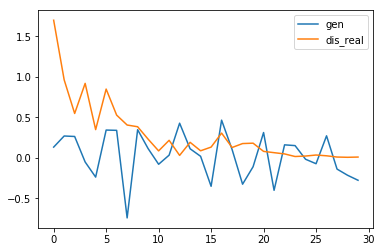

Generation 94  fitness : -25.86682688671168
#################################
population fitness : [ -25.06339282  -31.37939344 -109.35820175 -137.78637407  -91.35026098
 -113.49210673 -107.62156426  -52.12471115  -79.38888175  -47.96187377]
mean fit : -79.55267607124335
[0.  0.1 0.1 0.1 0.  0.  0.1 0.1 0.  0.1]
5.377851500341467
Evolving...
Choice : [7, 0, 2, 4, 1, 0, 9, 8, 6, 5, 0]


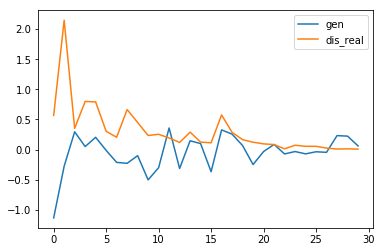

Generation 95  fitness : -25.06339281634106
#################################
population fitness : [ -64.03538723 -110.26249091  -81.03976075  -52.96953957  -27.18923181
 -110.1471401   -34.96639602 -106.98118319 -112.04186107 -100.73368575]
mean fit : -80.03666764028915
[0.1 0.1 0.1 0.  0.1 0.1 0.1 0.1 0.1 0. ]
5.183065252200953
Evolving...
Choice : [6, 5, 2, 3, 4, 4, 7, 1, 9, 4, 0]


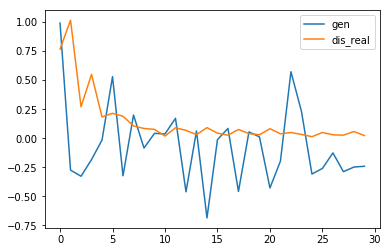

Generation 96  fitness : -27.18923180533277
#################################
population fitness : [-65.81956447 -82.80393373 -81.03624321 -28.55732945 -33.70623419
 -63.80269293 -79.37419293 -21.29583659 -43.35174434 -34.58107843]
mean fit : -53.43288502521585
[0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0. ]
5.179433514050183
Evolving...
Choice : [0, 9, 5, 7, 4, 6, 7, 3, 8, 2, 7]


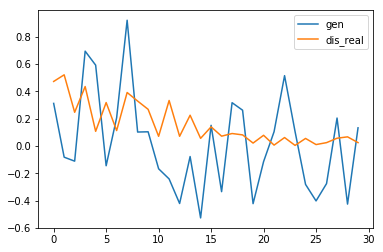

Generation 97  fitness : -21.295836586893824
#################################
population fitness : [ -41.06373048  -68.56343213  -35.10191158  -45.70162364  -79.49785667
  -39.91653573  -29.64427192  -78.15958054 -109.86509474  -78.76122532]
mean fit : -60.62752627283692
[0.  0.1 0.  0.  0.  0.  0.1 0.  0.1 0.1]
5.336494543251595
Evolving...
Choice : [7, 2, 0, 4, 1, 3, 6, 6, 5, 9, 6]


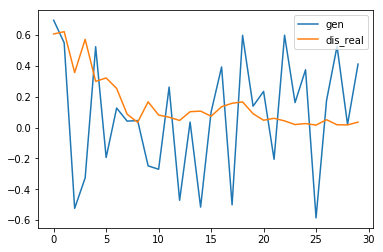

Generation 98  fitness : -29.644271915840044
#################################
population fitness : [ -56.34705408  -46.09418875  -44.08916706  -83.75457345  -84.12304713
 -115.25439421  -36.60925502  -38.03607988  -56.04990068 -145.86006546]
mean fit : -70.62177257134547
[0.1 0.1 0.1 0.1 0.  0.1 0.1 0.1 0.  0.1]
5.466022424401731
Evolving...
Choice : [8, 6, 1, 5, 6, 4, 3, 6, 7, 2, 0]


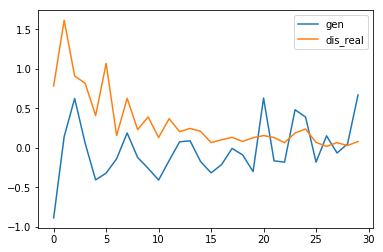

Generation 99  fitness : -36.60925502220787
#################################
population fitness : [ -41.29502044  -27.88416396  -59.17200029 -103.50569721  -30.51759143
  -74.83877251  -30.70299538  -43.0977403  -147.2917914   -93.81643718]
mean fit : -65.21222100970886
[0.1 0.  0.  0.  0.1 0.  0.  0.1 0.1 0. ]
5.492254336665979
Evolving...
Choice : [3, 4, 1, 7, 9, 0, 2, 1, 5, 1, 6]


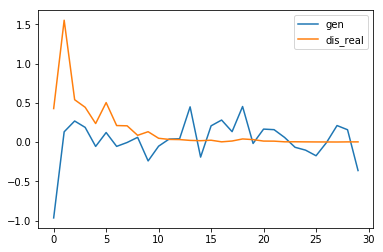

Generation 100  fitness : -27.88416395843277
#################################
population fitness : [-111.16904053 -110.33366505  -59.54336365  -51.30155342  -61.0389537
  -73.66062126  -39.63676449  -90.01516476  -67.77390892  -77.88997754]
mean fit : -74.23630133157889
[0.  0.  0.  0.1 0.1 0.  0.1 0.  0.  0.1]
5.2871628577869485
Evolving...
Choice : [6, 3, 4, 7, 9, 6, 8, 2, 5, 1, 6]


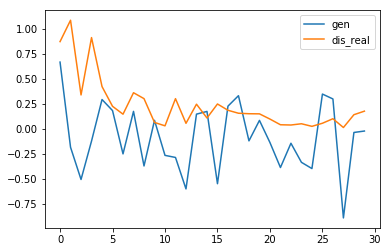

Generation 101  fitness : -39.63676448562613
#################################
population fitness : [ -66.14565254  -69.51294785 -120.09355442  -55.00872008  -60.5746573
  -52.15532518  -83.69259441  -48.70731228 -104.02455388 -108.63263365]
mean fit : -76.85479515878652
[0.1 0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
5.29398265236364
Evolving...
Choice : [1, 0, 4, 8, 7, 9, 6, 7, 3, 7, 5]


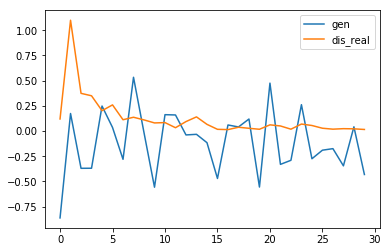

Generation 102  fitness : -48.70731227717178
#################################
population fitness : [ -49.69690845  -59.13152206 -107.97079391  -98.11176558  -17.78299352
  -48.89370189 -105.28848568  -37.03224833  -45.92517114 -108.96607369]
mean fit : -67.8799664240344
[0.  0.1 0.1 0.  0.1 0.1 0.1 0.1 0.  0. ]
5.297423902620657
Evolving...
Choice : [1, 0, 7, 4, 8, 6, 3, 2, 4, 4, 5]


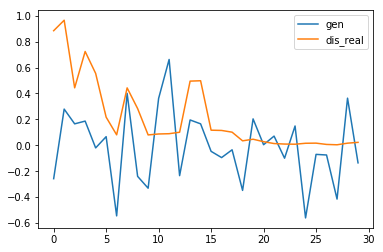

Generation 103  fitness : -17.782993517761373
#################################
population fitness : [ -58.18557372  -39.65520162 -115.27732827  -43.38813304  -14.53773589
 -122.96684585 -108.27450256  -90.26587782 -111.2489779  -106.8921754 ]
mean fit : -81.06923520685288
[0.1 0.1 0.1 0.  0.  0.1 0.  0.1 0.1 0. ]
5.256876181508965
Evolving...
Choice : [4, 9, 7, 1, 0, 4, 2, 8, 6, 3, 4]


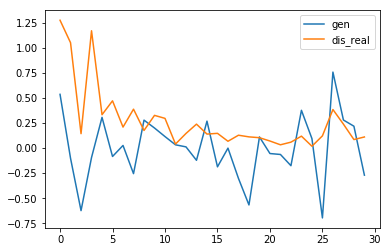

Generation 104  fitness : -14.537735888875874
#################################
population fitness : [ -65.97603162  -91.21842844  -93.27190782  -86.43816987 -104.88638439
  -42.5134673   -49.50548308 -110.4518128  -108.15890631 -131.62979517]
mean fit : -88.40503867960904
[0.  0.1 0.1 0.  0.  0.  0.1 0.  0.  0.1]
5.290355505390029
Evolving...
Choice : [2, 3, 5, 4, 7, 5, 8, 0, 5, 1, 6]


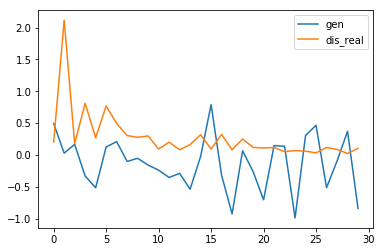

Generation 105  fitness : -42.513467304749376
#################################
population fitness : [-129.30895163 -107.34047141  -42.34348123 -120.74669582 -119.44949661
  -47.68201887  -75.12911921  -60.97267499  -65.68184618  -43.36884492]
mean fit : -81.20236008666548
[0.1 0.1 0.  0.1 0.1 0.1 0.1 0.  0.1 0.1]
5.317980599489886
Evolving...
Choice : [2, 3, 4, 2, 6, 7, 5, 9, 8, 1, 2]


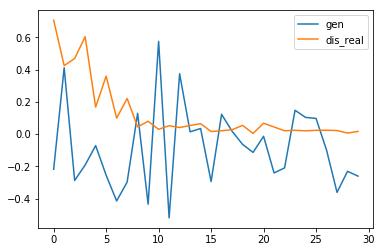

Generation 106  fitness : -42.34348123379984
#################################
population fitness : [ -19.68469464 -135.5422366  -104.64228566 -122.32495268 -109.1259657
  -39.36356703  -66.71743713  -84.62268039  -66.80249775  -37.87184377]
mean fit : -78.6698161348099
[0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1]
5.369669003573355
Evolving...
Choice : [5, 8, 2, 0, 4, 0, 9, 0, 3, 7, 6]


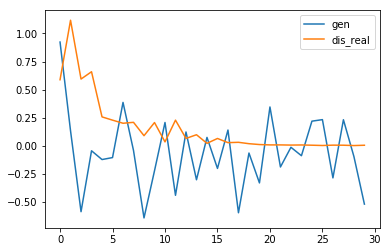

Generation 107  fitness : -19.68469463746118
#################################
population fitness : [-106.08598312  -92.2694444  -116.42948937  -45.67383211 -110.57051603
  -78.67954818   30.38326061 -109.68414294  -47.8098212    24.44799662]
mean fit : -65.2371520114065
[0.  0.1 0.  0.  0.1 0.1 0.  0.  0.  0.1]
5.30479809716252
Evolving...
Choice : [6, 6, 4, 9, 1, 6, 8, 5, 0, 7, 3]


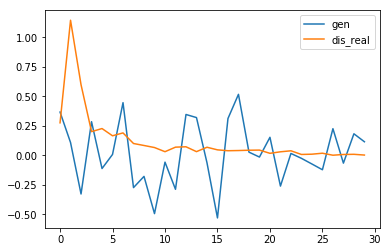

Generation 108  fitness : 30.38326060578305
#################################
population fitness : [  -9.64982338  -74.93286883 -119.71728907  -33.93814411  -62.32857847
  -70.41733286  -53.50842379 -107.9109825   -62.63528477  -29.62744635]
mean fit : -62.46661741300162
[0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.1]
5.379814844389919
Evolving...
Choice : [0, 3, 7, 0, 6, 0, 4, 9, 8, 5, 1]


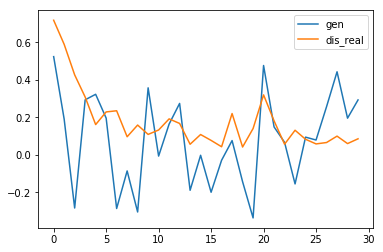

Generation 109  fitness : -9.649823376988374
#################################
population fitness : [ -35.966343      1.60537785  -67.93565544  -29.66631902  -38.63989834
   14.49109752  -60.68140729  -79.01858364  -59.75991749 -102.64144472]
mean fit : -45.82130935537448
[0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.1]
5.373725059638166
Evolving...
Choice : [5, 7, 5, 0, 2, 1, 3, 8, 4, 6, 5]


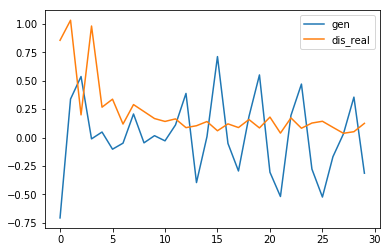

Generation 110  fitness : 14.491097522836842
#################################
population fitness : [-156.4089581   -26.83011914  -36.73095683 -101.52096846    3.13501532
  -92.49493416  -63.39179353 -104.87341295  -69.13512164  -75.78831981]
mean fit : -72.40395692981163
[0.1 0.1 0.  0.1 0.1 0.  0.1 0.1 0.  0.1]
5.496364450994433
Evolving...
Choice : [4, 4, 6, 1, 2, 9, 5, 7, 4, 8, 3]


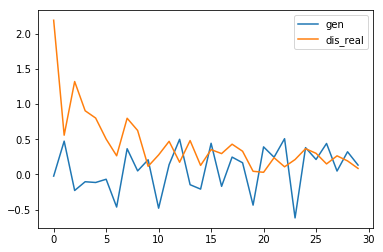

Generation 111  fitness : 3.1350153155394853
#################################
population fitness : [-135.32059661  -79.20893935  -32.87056575  -71.15311356   81.43402038
  -79.56899239  -68.24423061  -60.66434516  -49.65261541  -62.66768497]
mean fit : -55.79170634167805
[0.1 0.1 0.  0.1 0.1 0.  0.1 0.  0.  0.1]
5.473301001344081
Evolving...
Choice : [7, 8, 4, 2, 4, 5, 3, 9, 1, 4, 6]


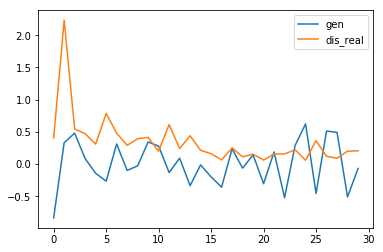

Generation 112  fitness : 81.43402038368053
#################################
population fitness : [-112.79599679  -52.22501586  -44.82460955  -96.15563618  -13.73823304
 -142.42906912 -108.72632911  -42.01182697 -109.02085628 -135.94063522]
mean fit : -85.78682081160149
[0.1 0.1 0.  0.1 0.1 0.1 0.  0.  0.1 0. ]
5.365104670783764
Evolving...
Choice : [8, 3, 7, 6, 1, 2, 4, 4, 0, 9, 4]


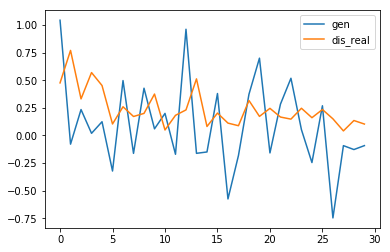

Generation 113  fitness : -13.738233038120567
#################################
population fitness : [-123.62070326  -86.85182134  -61.45541578  -53.03282679  -42.76371092
  -19.80929613  -54.67050076 -108.90164386 -126.41775475  -37.40802958]
mean fit : -71.49317031563062
[0.  0.  0.1 0.  0.  0.  0.1 0.  0.  0.1]
5.3759095311363545
Evolving...
Choice : [5, 3, 6, 2, 4, 1, 7, 0, 5, 5, 9]


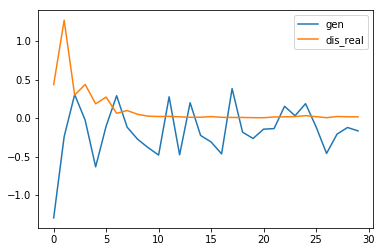

Generation 114  fitness : -19.809296125959047
#################################
population fitness : [ -58.64588679 -100.36196368   10.75817594 -101.58254328  -47.8447512
 -108.22021533 -110.87745776  -77.95450061   -7.63936229  -63.22450592]
mean fit : -66.55930109090146
[0.  0.1 0.  0.  0.1 0.  0.1 0.1 0.1 0. ]
5.283472249040196
Evolving...
Choice : [2, 1, 2, 8, 0, 7, 3, 5, 9, 4, 2]


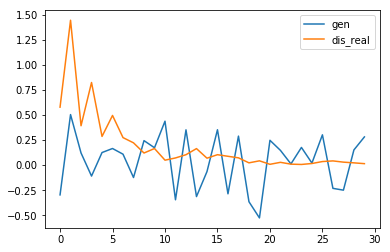

Generation 115  fitness : 10.758175941977633
#################################
population fitness : [ -76.75704768 -110.13568492  -33.3979821   -97.69468398  -55.10361553
  -94.22284448  -99.28764317  -31.70934347  -98.06218404  -88.23550039]
mean fit : -78.46065297865927
[0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.  0.1]
5.177180700939076
Evolving...
Choice : [2, 7, 4, 3, 0, 6, 5, 7, 9, 7, 8]


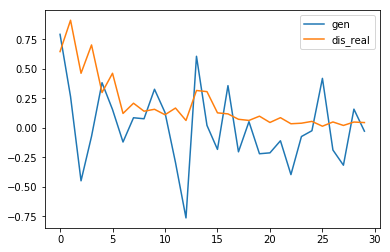

Generation 116  fitness : -31.709343474878743
#################################
population fitness : [ -66.21485964  -28.956421    -82.61221925  -47.26514187 -106.25031374
  -64.26267311 -127.47565033   45.74845665 -111.82488766  -30.58726517]
mean fit : -61.97009751345007
[0.  0.  0.  0.1 0.1 0.1 0.  0.  0.1 0. ]
5.406950388536514
Evolving...
Choice : [2, 1, 0, 5, 9, 7, 7, 8, 3, 4, 7]


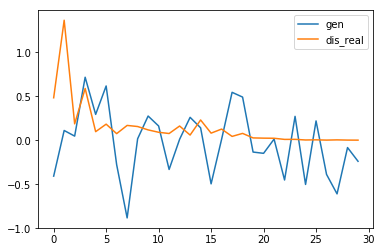

Generation 117  fitness : 45.74845664819101
#################################
population fitness : [ -51.36281733  -44.09619134  -68.13285227  -27.5521905   -49.28376355
  -11.00586464  -79.59711509  -99.38693878 -142.98400423  -62.91696513]
mean fit : -63.63187028597365
[0.1 0.1 0.1 0.  0.1 0.  0.1 0.  0.  0. ]
5.482838481597438
Evolving...
Choice : [7, 5, 2, 1, 6, 9, 0, 4, 3, 5, 5]


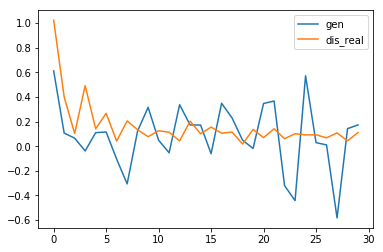

Generation 118  fitness : -11.005864642036459
#################################
population fitness : [-112.20757953 -106.61348344  -70.00900251  -57.02343927  163.93685652
  -68.8217024  -100.4367954   -68.02872933  -62.44638935  158.85646662]
mean fit : -32.279379808053946
[0.  0.1 0.  0.  0.1 0.1 0.1 0.  0.1 0. ]
5.41750794873125
Evolving...
Choice : [1, 3, 4, 6, 4, 2, 7, 5, 9, 4, 8]


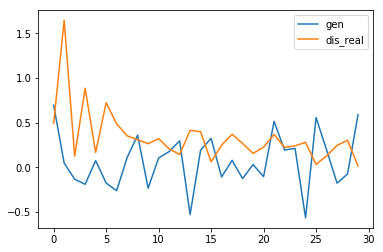

Generation 119  fitness : 163.93685652298876
#################################
population fitness : [-133.03646806  -75.39756144    8.69603595  -76.76516378  -48.039764
  -45.2703718   -96.1787177   -60.04287862  -78.18748676 -100.4845309 ]
mean fit : -70.47069071085865
[0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.1]
5.404544264853822
Evolving...
Choice : [2, 9, 5, 8, 2, 7, 4, 3, 2, 6, 1]


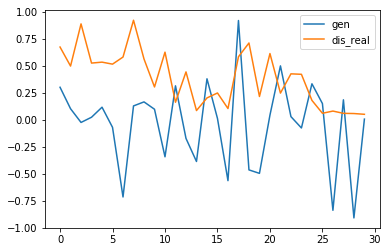

Generation 120  fitness : 8.696035946405232
#################################
population fitness : [ 122.74992119  -22.5486254   -54.39690859  -33.91824532  -93.31318719
  -59.73031876  102.45018901 -167.07661153  -76.85277507  -26.60308522]
mean fit : -30.923964687998108
[0.  0.1 0.  0.1 0.  0.  0.1 0.  0.  0.1]
5.635562005751998
Evolving...
Choice : [4, 0, 1, 2, 3, 0, 5, 6, 9, 0, 8]


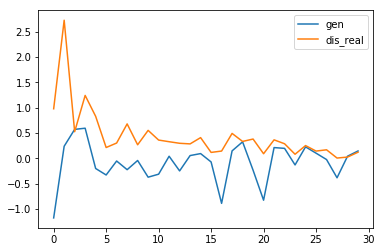

Generation 121  fitness : 122.74992119418893
#################################
population fitness : [-104.96844819  -96.52728636  -71.92458655  -35.61497802 -109.18394496
  -96.67584197  -94.06229794  -99.68284563 -110.86729763  -80.84312515]
mean fit : -90.03506524021392
[0.  0.  0.  0.  0.1 0.1 0.1 0.  0.1 0.1]
5.049877159349134
Evolving...
Choice : [4, 2, 3, 5, 0, 9, 3, 6, 7, 3, 1]


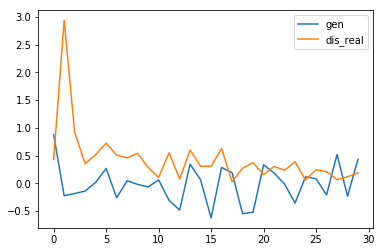

Generation 122  fitness : -35.61497802225196
#################################
population fitness : [ -62.98408059  -78.37385671  -70.02141113 -101.8440018  -124.29663658
  -79.56584481  -87.74315506  -87.83264535  -65.28227038  -49.79209004]
mean fit : -80.77359924500526
[0.  0.1 0.  0.1 0.  0.1 0.  0.1 0.1 0. ]
5.302102907829798
Evolving...
Choice : [1, 5, 3, 8, 9, 2, 6, 0, 9, 7, 9]


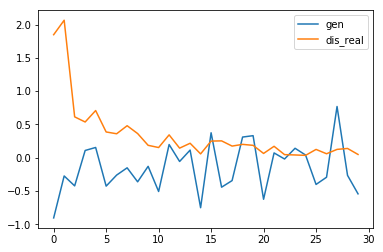

Generation 123  fitness : -49.79209004135836
#################################
population fitness : [-92.94362415  55.59192116 -84.09220448 -40.21443717 -54.88485818
 -64.92661347 -55.54767001 -45.52423482 -39.54666909 -88.44975204]
mean fit : -51.05381422437579
[0.1 0.1 0.1 0.  0.  0.1 0.  0.  0.  0.1]
5.2629714965281655
Evolving...
Choice : [6, 1, 9, 1, 7, 8, 5, 1, 3, 2, 4]


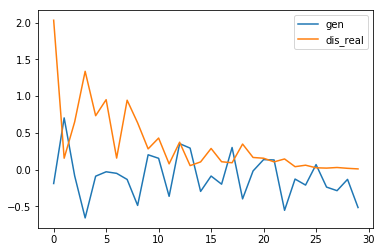

Generation 124  fitness : 55.59192116422273
#################################
population fitness : [ -59.05908802 -161.48132836  -59.53174739  -78.2459027   -69.19657392
  -56.87859246  -76.83418226  -95.57508903  -85.54954417  -58.738471  ]
mean fit : -80.10905193031468
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.1]
5.494520415828664
Evolving...
Choice : [5, 0, 5, 3, 9, 2, 8, 5, 7, 4, 6]


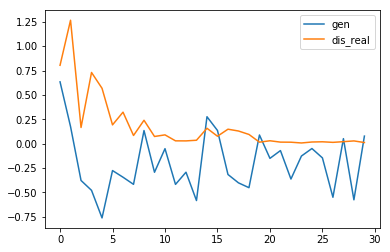

Generation 125  fitness : -56.87859245786808
#################################
population fitness : [ -75.01713384  -57.40419017  -31.86658318 -104.59217412 -139.3944276
  -97.60276589  -96.49291164  -31.45177131 -107.56089735 -161.78693851]
mean fit : -90.31697936171227
[0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0. ]
5.444566932590427
Evolving...
Choice : [8, 0, 5, 3, 4, 7, 6, 1, 7, 7, 2]


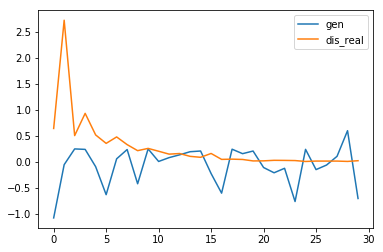

Generation 126  fitness : -31.451771307584462
#################################
population fitness : [  47.84818331  109.42634622  -56.31839342  -70.52774964 -111.26384332
   14.04321098  -48.09565095  -67.19377189  -39.25970004  -41.05897657]
mean fit : -26.240034532091876
[0.  0.  0.1 0.  0.  0.1 0.1 0.1 0.1 0. ]
5.485361261709373
Evolving...
Choice : [2, 8, 6, 1, 0, 1, 3, 7, 5, 1, 9]


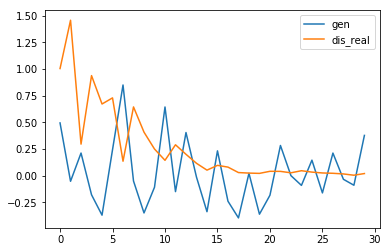

Generation 127  fitness : 109.42634621935032
#################################
population fitness : [ -95.18640726  -36.3404421  -103.78010872 -105.82861982   86.03323971
  -75.39878945  -83.83921911  -86.64733361  165.15997852  -54.00190342]
mean fit : -38.982960526836465
[0.  0.1 0.  0.  0.  0.1 0.1 0.  0.  0.1]
5.365773799848021
Evolving...
Choice : [7, 8, 4, 5, 6, 9, 2, 8, 8, 1, 0]


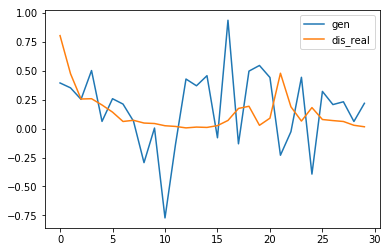

Generation 128  fitness : 165.1599785243184
#################################
population fitness : [  24.71225927  153.47575112  -95.32957504  -61.47318443  -12.5973115
   -7.27336779 -101.73734414 -108.28796207 -176.59417035  -63.79718625]
mean fit : -44.890209116580905
[0.1 0.  0.1 0.  0.  0.  0.1 0.1 0.1 0.1]
5.622026108122174
Evolving...
Choice : [0, 1, 7, 5, 3, 2, 1, 9, 1, 4, 6]


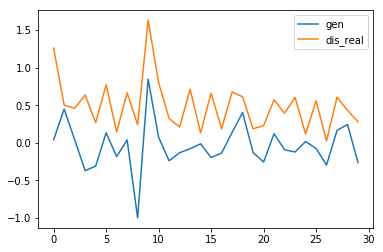

Generation 129  fitness : 153.4757511154766
#################################
population fitness : [  68.93925131 -114.97799828 -103.49945091  -79.54370471 -138.46408786
   47.94470348  -54.18766175  -55.79636007  -62.19399529    7.54416832]
mean fit : -48.42351357771024
[0.  0.1 0.  0.  0.  0.1 0.  0.  0.  0.1]
5.500828213029679
Evolving...
Choice : [0, 8, 3, 5, 7, 6, 0, 9, 0, 1, 2]


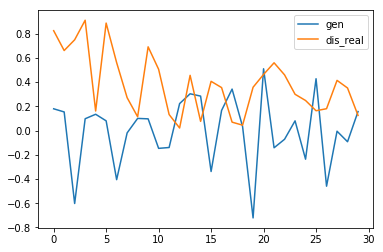

Generation 130  fitness : 68.9392513085398
#################################
population fitness : [ -66.33855481  -31.61419065 -108.67734017 -107.89959334  -85.80954608
 -100.38144124  121.58288416 -119.15039979  -77.7564012  -100.16555839]
mean fit : -67.62101415082222
[0.  0.1 0.1 0.  0.1 0.  0.  0.  0.  0.1]
5.283330497357601
Evolving...
Choice : [6, 3, 2, 0, 6, 8, 6, 4, 1, 9, 5]


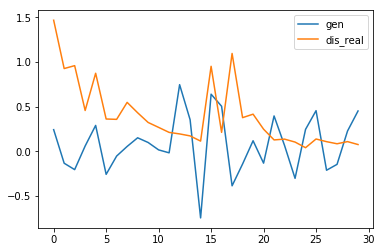

Generation 131  fitness : 121.58288415805065
#################################
population fitness : [  96.81725962    8.69139315  -89.73041732  178.07023934  -77.94017032
  -80.5962116   -27.75975826  -34.80378831 -107.47481422 -104.85712407]
mean fit : -23.958339199890148
[0.1 0.  0.  0.1 0.  0.1 0.1 0.  0.1 0. ]
5.461587135451639
Evolving...
Choice : [4, 7, 6, 3, 0, 9, 5, 3, 2, 1, 3]


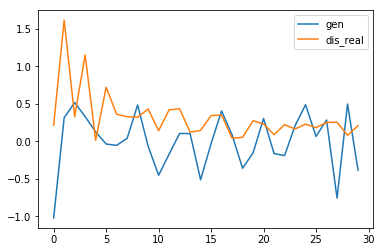

Generation 132  fitness : 178.07023933827983
#################################
population fitness : [ -85.49910341  -78.58248597 -100.10219442 -120.83591923  -62.22000729
 -118.99614625  -59.32703449 -121.05094191  -82.28859264  -98.17669303]
mean fit : -92.70791186426811
[0.1 0.1 0.1 0.1 0.  0.1 0.  0.1 0.1 0.1]
5.245021070628774
Evolving...
Choice : [5, 6, 9, 2, 3, 4, 6, 1, 0, 8, 6]


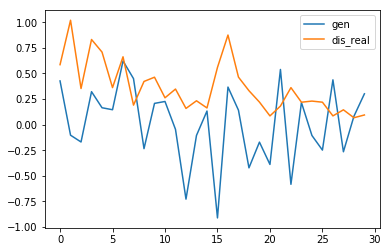

Generation 133  fitness : -59.32703449422909
#################################
population fitness : [-102.38982649 -111.16742821 -158.66242212 -147.21259157 -105.83776517
 -103.58291534 -113.53452209  -73.52086184 -111.66814699 -106.14850515]
mean fit : -113.37249849686593
[0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1 0.  0.1]
5.313160623851431
Evolving...
Choice : [6, 7, 7, 7, 4, 3, 8, 5, 9, 0, 1]


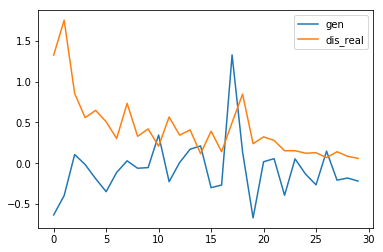

Generation 134  fitness : -73.5208618413402
#################################
population fitness : [ -88.52173768  -74.34338531 -117.25453664 -160.84064872  225.44565102
 -164.26219121 -105.74564058 -181.88066545 -103.78215467 -121.50728247]
mean fit : -89.26925917119432
[0.  0.1 0.1 0.  0.1 0.  0.  0.1 0.  0.1]
5.4767046004727975
Evolving...
Choice : [4, 5, 4, 8, 9, 2, 4, 6, 0, 3, 1]


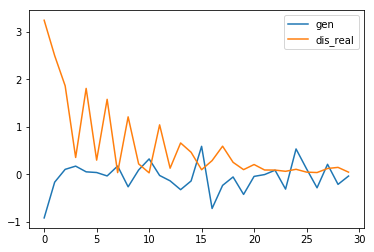

Generation 135  fitness : 225.44565101732107
#################################
population fitness : [ -92.20065431 -132.91579121  -40.67235073 -110.79118618  -57.32566226
  -73.3298968   -30.57169874  -99.29840702  -89.50226423  -75.72817745]
mean fit : -80.23360889328686
[0.1 0.  0.1 0.  0.1 0.  0.1 0.1 0.  0.1]
5.353073543868954
Evolving...
Choice : [8, 2, 0, 4, 9, 5, 6, 7, 3, 6, 6]


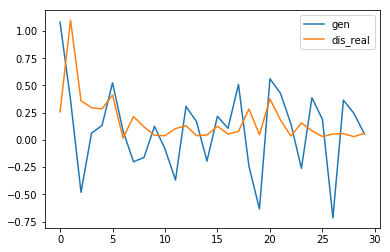

Generation 136  fitness : -30.571698738860007
#################################
population fitness : [-103.4810962  -116.75073711 -116.79496961  -44.78623643 -103.88595035
  -77.71825471  -96.21269858  -40.9285384  -115.06450915  -83.93207825]
mean fit : -89.95550687813888
[0.1 0.1 0.  0.1 0.1 0.  0.1 0.1 0.1 0. ]
5.2938540729257415
Evolving...
Choice : [9, 3, 7, 1, 5, 7, 7, 6, 8, 4, 0]


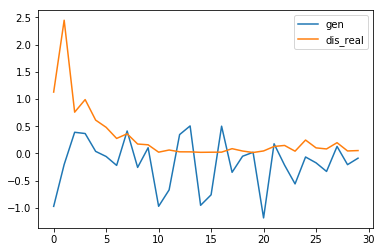

Generation 137  fitness : -40.928538397962214
#################################
population fitness : [ -56.45355322  -90.23992917 -110.67306023 -108.2406324  -101.24088101
  -93.92628695 -113.44452805 -143.78918673 -110.30545227 -165.79815396]
mean fit : -109.41116639959372
[0.  0.  0.1 0.  0.1 0.  0.1 0.  0.  0.1]
5.378125636799417
Evolving...
Choice : [8, 5, 2, 0, 0, 1, 7, 4, 0, 6, 3]


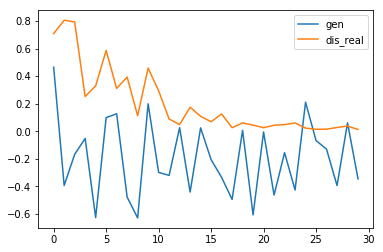

Generation 138  fitness : -56.45355322478338
#################################
population fitness : [ -80.99351623 -114.77419252 -125.80199607  -43.44630188  110.96360771
 -121.16096493 -106.10855127  -96.14085952  -93.47872296 -109.01748706]
mean fit : -77.99589847257717
[0.1 0.  0.  0.1 0.  0.  0.  0.1 0.1 0.1]
5.2543759522138815
Evolving...
Choice : [7, 8, 0, 4, 1, 4, 5, 6, 3, 9, 4]


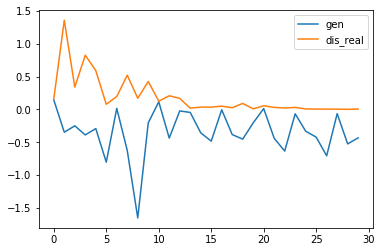

Generation 139  fitness : 110.96360770610582
#################################
population fitness : [-112.39800339   30.41581624  -69.72091274 -150.19071053 -117.22083661
  -80.47490769  -97.14480241 -115.65673358 -100.53673578  -77.98134805]
mean fit : -89.0909174546218
[0.  0.  0.1 0.  0.1 0.  0.1 0.  0.  0. ]
5.387670565123217
Evolving...
Choice : [6, 4, 1, 2, 7, 8, 5, 0, 1, 9, 1]


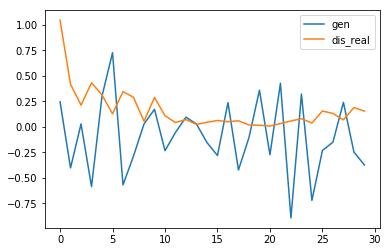

Generation 140  fitness : 30.415816238306512
#################################
population fitness : [-126.06053095  -78.03552617   15.62528638  -76.35368263  -40.45551835
 -100.16888017  -90.77166371  -93.91136953  -48.34662837 -110.59128659]
mean fit : -74.90698000948451
[0.1 0.  0.  0.1 0.1 0.  0.  0.  0.1 0.1]
5.3310258357199425
Evolving...
Choice : [2, 3, 5, 4, 9, 6, 2, 2, 8, 7, 1]


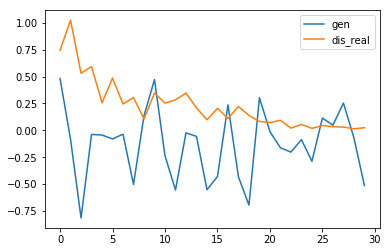

Generation 141  fitness : 15.625286380595838
#################################
population fitness : [-105.1364662  -109.32954928  -99.0472025   -46.13497161  -83.84143543
 -155.21327496   26.46405983 -117.41880268   81.62667746  -99.53188365]
mean fit : -70.75628490169082
[0.  0.1 0.1 0.  0.  0.1 0.1 0.1 0.  0. ]
5.476422685216741
Evolving...
Choice : [4, 8, 2, 1, 8, 3, 9, 6, 8, 7, 0]


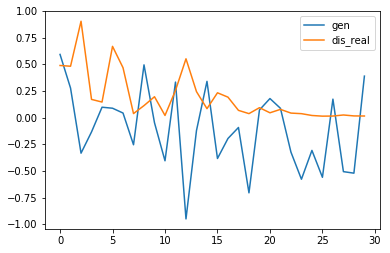

Generation 142  fitness : 81.62667746319885
#################################
population fitness : [ -93.97526663  -43.12888651 -132.24641862  -97.98916678 -107.61413596
  -92.90441136 -118.75385276   59.93933141  -84.96647323   63.56865294]
mean fit : -64.80706274947943
[0.  0.1 0.  0.  0.1 0.  0.  0.1 0.  0.1]
5.389828737488559
Evolving...
Choice : [6, 7, 4, 8, 1, 9, 3, 5, 9, 9, 0]


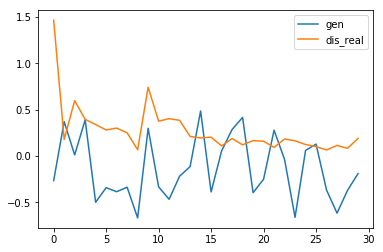

Generation 143  fitness : 63.56865294434639
#################################
population fitness : [-121.27115962 -115.15828073  121.59935117  -29.81139056 -143.5113595
   68.66962465 -111.38597105  -89.29453646  -98.41151951  137.24455358]
mean fit : -38.13306880218677
[0.1 0.1 0.1 0.  0.1 0.  0.1 0.1 0.1 0. ]
5.51937112485394
Evolving...
Choice : [9, 6, 5, 3, 9, 1, 9, 0, 8, 7, 2]


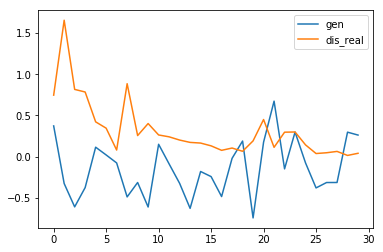

Generation 144  fitness : 137.24455357739936
#################################
population fitness : [ 182.79715505 -137.56747032   67.27887838   77.19284608  139.32901261
 -102.85598313  -93.77869117 -118.83892332  -50.53619464 -129.12405531]
mean fit : -16.61034257892863
[0.  0.1 0.1 0.  0.  0.1 0.  0.1 0.1 0. ]
5.5655984284052975
Evolving...
Choice : [9, 3, 4, 0, 5, 0, 8, 2, 7, 0, 6]


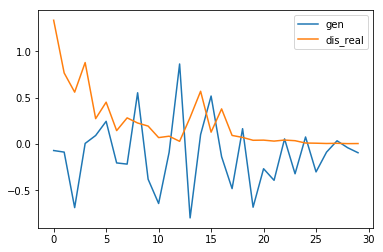

Generation 145  fitness : 182.7971550479819
#################################
population fitness : [-164.14060649  -49.88436446  -91.49906987   -3.51382282 -104.49272978
 -107.38971297  175.15683594   32.4275594  -138.05411112 -101.65623054]
mean fit : -55.30462527050729
[0.1 0.  0.  0.1 0.1 0.1 0.1 0.  0.1 0. ]
5.5463830842891895
Evolving...
Choice : [1, 4, 3, 7, 9, 6, 6, 5, 8, 2, 6]


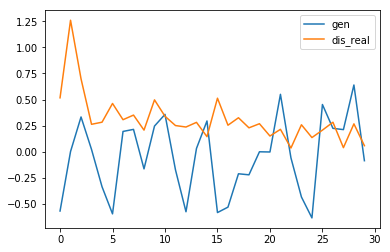

Generation 146  fitness : 175.15683594413468
#################################
population fitness : [ -78.27224491 -107.63808504  -13.3314188    72.26745338  112.65877439
  -96.64146604  -67.59235959 -106.43508611 -142.7136035   -83.97730227]
mean fit : -51.16753384864188
[0.  0.1 0.  0.  0.1 0.1 0.1 0.  0.  0.1]
5.494442480039504
Evolving...
Choice : [9, 4, 1, 4, 3, 4, 6, 2, 5, 0, 7]


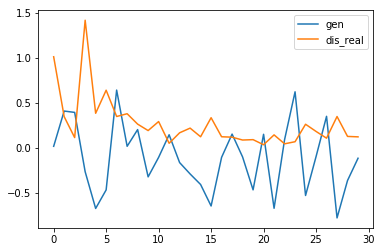

Generation 147  fitness : 112.65877439276625
#################################
population fitness : [ -48.5412969   -68.64128352 -114.62156619  -96.32515494   -8.98043963
 -117.61497874  -31.77497411  -92.16342076  -99.79057654 -109.73155726]
mean fit : -78.81852485767567
[0.1 0.1 0.  0.1 0.1 0.1 0.  0.1 0.  0.1]
5.2384623565244635
Evolving...
Choice : [9, 4, 2, 1, 3, 0, 4, 4, 7, 6, 8]


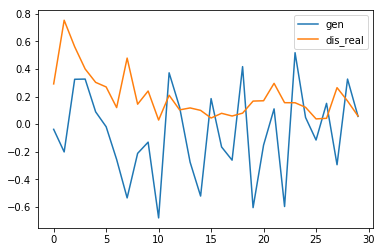

Generation 148  fitness : -8.980439633527059
#################################
population fitness : [-100.32275139   86.44880339  -64.31854599 -107.86953812  -97.03881451
  -92.28072058   52.49596388 -100.96533269   59.57310964 -135.47173205]
mean fit : -49.97495584116476
[0.1 0.1 0.1 0.  0.1 0.1 0.  0.1 0.1 0. ]
5.464838133838894
Evolving...
Choice : [1, 5, 6, 7, 0, 1, 8, 3, 2, 4, 1]


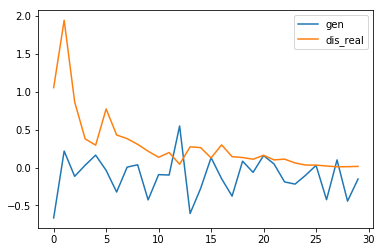

Generation 149  fitness : 86.44880339194218
#################################
population fitness : [ -13.82339842  -98.5675672   -34.12699947  -82.84691267 -119.95781249
  -90.37226579 -107.46998856 -100.15997344 -105.58247619  -94.31145525]
mean fit : -84.72188494702762
[0.  0.1 0.1 0.  0.  0.  0.  0.  0.  0. ]
5.206817125882902
Evolving...
Choice : [7, 0, 8, 9, 0, 1, 5, 3, 0, 2, 6]


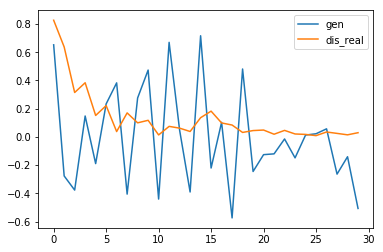

Generation 150  fitness : -13.823398421316725
#################################
population fitness : [ -91.97789916   -9.28759676 -145.97006118  -73.62353132  -31.86730344
  -98.88553883 -113.1568151   -81.65879554  -98.57026668 -105.36032056]
mean fit : -85.0358128576603
[0.1 0.  0.  0.  0.1 0.1 0.  0.1 0.1 0.1]
5.394229567949543
Evolving...
Choice : [1, 6, 0, 1, 5, 8, 4, 3, 9, 7, 1]


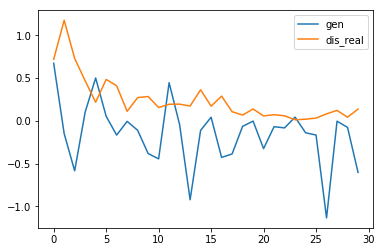

Generation 151  fitness : -9.287596763343258
#################################
population fitness : [ 113.04474306  -63.72085383  -44.20460188  -95.68100963  -97.12164772
 -118.78415994   -8.87251401  -96.87320788 -182.7356715   -58.67562575]
mean fit : -65.36245490970138
[0.1 0.  0.1 0.  0.1 0.1 0.  0.  0.  0.1]
5.590039717525803
Evolving...
Choice : [0, 4, 9, 0, 2, 3, 0, 6, 5, 1, 7]


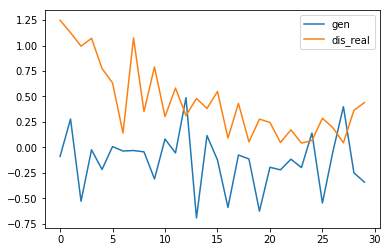

Generation 152  fitness : 113.04474305970992
#################################
population fitness : [  82.23647984 -122.72701065   65.92243977  -95.46871815  -76.10722871
 -160.45092205  -71.85092427 -101.97723659  -67.1307739  -124.0818527 ]
mean fit : -67.16357474046453
[0.1 0.  0.  0.1 0.  0.1 0.1 0.1 0.  0. ]
5.505857033642633
Evolving...
Choice : [4, 0, 8, 1, 7, 0, 0, 3, 2, 6, 9]


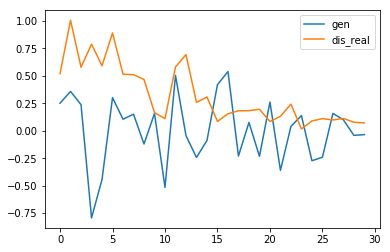

Generation 153  fitness : 82.23647984000927
#################################
population fitness : [-107.4346362     4.31316228 -110.29807363 -151.91951971  -99.58489131
 -105.34551772    3.77069931   14.01199093  -89.80204636 -168.74977605]
mean fit : -81.10386084501015
[0.1 0.  0.1 0.1 0.  0.1 0.  0.1 0.1 0. ]
5.495272092939897
Evolving...
Choice : [2, 8, 1, 7, 3, 5, 7, 6, 0, 4, 7]


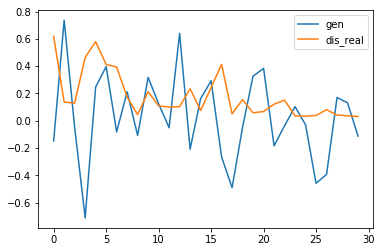

Generation 154  fitness : 14.011990931035902
#################################
population fitness : [ -97.64326334 -115.38113574 -147.50530869 -147.51580475 -100.75037642
 -140.5152159  -104.5601061   -31.4421681  -106.06362448 -104.73742758]
mean fit : -109.61144310890843
[0.1 0.1 0.1 0.1 0.  0.1 0.  0.1 0.  0.1]
5.573148207286724
Evolving...
Choice : [9, 2, 5, 7, 1, 0, 6, 7, 7, 4, 8]


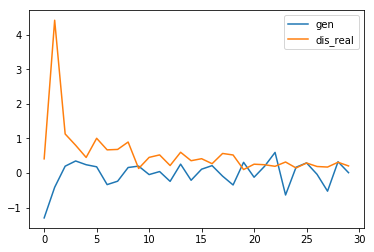

Generation 155  fitness : -31.442168098469825
#################################
population fitness : [ -86.28483396 -106.39301258 -102.3705736   -89.43618694  -92.83248601
 -106.12457809  -96.05642368    1.77613311  -81.75205406 -104.00546931]
mean fit : -86.34794851248218
[0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1]
5.03401203982429
Evolving...
Choice : [3, 4, 6, 7, 7, 9, 8, 2, 0, 7, 5]


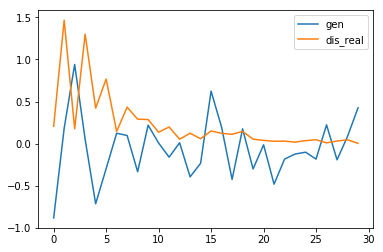

Generation 156  fitness : 1.776133105890258
#################################
population fitness : [ -83.95067873  -98.74757196 -100.34703478   76.23436447   95.59369445
 -100.57433173 -112.47691879  -71.52784481  -48.45023326  -99.22578768]
mean fit : -54.34723428180301
[0.  0.  0.1 0.  0.1 0.1 0.1 0.1 0.  0. ]
5.310837910155738
Evolving...
Choice : [0, 8, 3, 4, 4, 5, 2, 4, 9, 1, 7]


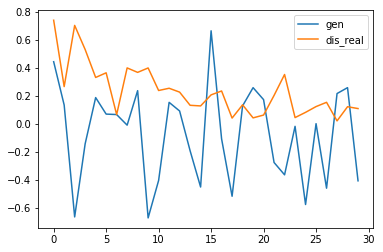

Generation 157  fitness : 95.59369444665869
#################################
population fitness : [-104.49940399  -75.937676     -1.76032128   64.6671775    70.21599536
 -127.27879677 -100.47017283 -105.68904282  -20.53589537 -110.68673253]
mean fit : -51.19748687262042
[0.  0.  0.  0.1 0.  0.1 0.1 0.1 0.  0.1]
5.42745259481823
Evolving...
Choice : [4, 9, 7, 4, 8, 3, 4, 1, 6, 2, 0]


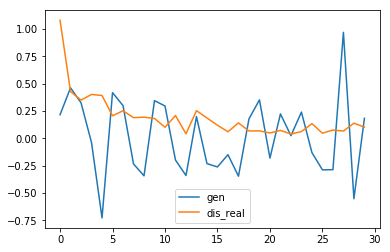

Generation 158  fitness : 70.21599535809152
#################################
population fitness : [ -47.64212173 -111.81491597  -42.34745309  -64.56829655    9.57420117
  129.64243601   -1.45637741  -92.37243006 -177.17413978   27.30001926]
mean fit : -37.08590781488581
[0.  0.  0.1 0.  0.  0.  0.  0.  0.1 0. ]
5.6456798605938765
Evolving...
Choice : [2, 9, 1, 7, 5, 5, 5, 3, 0, 4, 6]


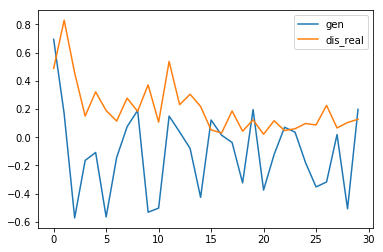

Generation 159  fitness : 129.64243600740042
#################################
population fitness : [ -97.92206854  -63.93452024 -105.79289988 -116.50403579  108.05429175
  122.09195805   43.83196084   88.29427956  -42.303528   -132.73972077]
mean fit : -19.692428301859444
[0.  0.1 0.  0.1 0.  0.  0.1 0.1 0.1 0.1]
5.555120894047963
Evolving...
Choice : [2, 5, 5, 7, 4, 6, 1, 5, 8, 3, 0]


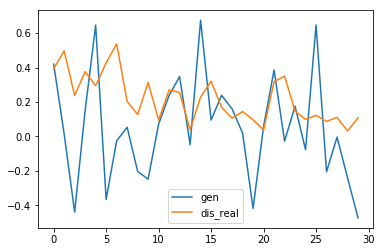

Generation 160  fitness : 122.09195805243795
#################################
population fitness : [ -99.86557989  101.16582227   -5.38260254  131.04255363   -2.50893953
    8.5573747  -118.66139578   11.86420108   61.28657844 -108.45199296]
mean fit : -2.0953980590220183
[0.  0.1 0.  0.1 0.  0.  0.  0.1 0.1 0. ]
5.586005753795786
Evolving...
Choice : [0, 5, 7, 2, 8, 4, 3, 3, 1, 3, 9]


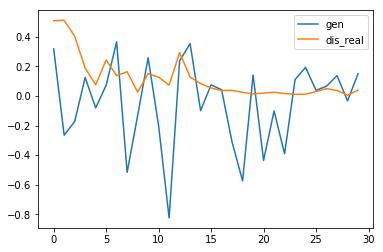

Generation 161  fitness : 131.0425536286111
#################################
population fitness : [ -92.25927892  -56.33600483   29.83044239   98.73109565  -97.60297726
   96.64313448 -151.76329334 -117.3673541   -99.97335128  -34.90015316]
mean fit : -42.49977403735021
[0.  0.1 0.  0.1 0.  0.1 0.  0.  0.1 0.1]
5.553890928351311
Evolving...
Choice : [8, 3, 4, 5, 7, 0, 3, 9, 1, 2, 3]


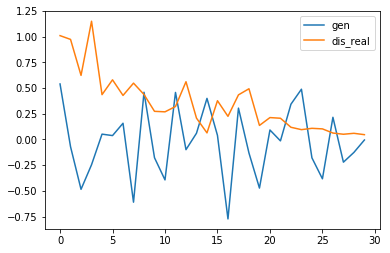

Generation 162  fitness : 98.73109564911817
#################################
population fitness : [  81.32988325   51.34371648 -132.84458964  -94.16611838 -217.12844268
 -105.15427215 -105.48217326 -135.92515212   70.32924742  105.40929743]
mean fit : -48.228860366416896
[0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.  0.1]
5.695131654410937
Evolving...
Choice : [7, 9, 9, 1, 0, 2, 5, 8, 9, 3, 6]


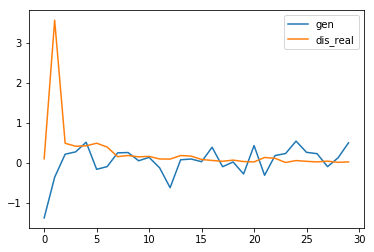

Generation 163  fitness : 105.40929742977957
#################################
population fitness : [ 156.43375401  125.69811511  -36.50054286   71.89812816   89.17132409
  -46.38018273 -103.55177967   74.62072688  -69.72561189  111.46679642]
mean fit : 37.313072752428205
[0.  0.  0.  0.1 0.1 0.  0.  0.1 0.1 0. ]
5.641458773396839
Evolving...
Choice : [4, 3, 9, 0, 0, 0, 5, 1, 8, 7, 2]


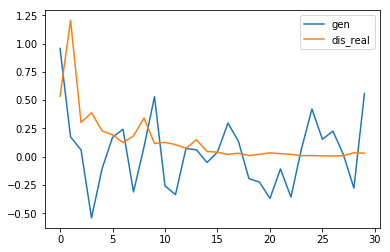

Generation 164  fitness : 156.43375400640298
#################################
population fitness : [157.83250778 -76.35300075 163.21358368 138.01152595 147.35076392
 135.23949691 116.35349309  61.68206554 109.22973131 -81.88270162]
mean fit : 87.06774658123564
[0.1 0.1 0.  0.1 0.1 0.1 0.1 0.  0.  0.1]
5.729771955794938
Evolving...
Choice : [1, 4, 0, 3, 2, 7, 2, 6, 8, 2, 5]


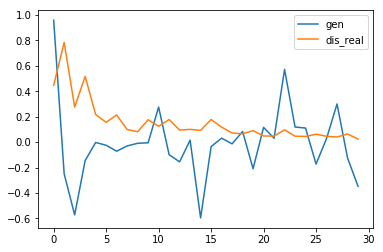

Generation 165  fitness : 163.21358368185773
#################################
population fitness : [ 142.14400293 -118.30433554  -87.97083726  -76.38309152 -102.39964592
   92.26970795  164.20510041 -102.68466833   81.60599409  120.87519936]
mean fit : 11.335742614884428
[0.  0.  0.1 0.1 0.  0.  0.  0.  0.  0. ]
5.591277872124051
Evolving...
Choice : [8, 6, 9, 4, 6, 0, 7, 2, 5, 6, 3]


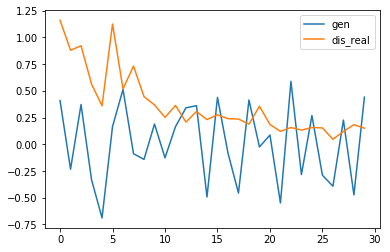

Generation 166  fitness : 164.2051004064799
#################################
population fitness : [ 130.57685839  -70.22268682  -98.3515395   -85.31026535  113.68770798
   31.21375689 -148.20557511   45.68812469  -12.606624     90.67909568]
mean fit : -0.2851147144857933
[0.  0.1 0.  0.  0.1 0.1 0.1 0.1 0.  0. ]
5.656123782347256
Evolving...
Choice : [2, 7, 3, 4, 9, 0, 8, 0, 5, 0, 1]


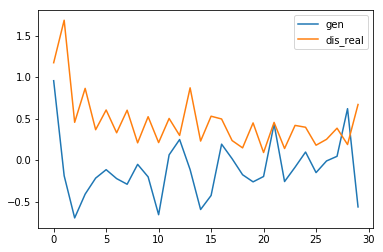

Generation 167  fitness : 130.57685838663213
#################################
population fitness : [ 111.11118128 -117.48798154   41.36118536  162.5593417   185.74861282
  121.236334    -24.39484459  -69.62564947  -37.68083521  -36.62503046]
mean fit : 33.620231389607326
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1]
5.659446688565557
Evolving...
Choice : [5, 3, 7, 4, 6, 4, 0, 2, 4, 9, 8]


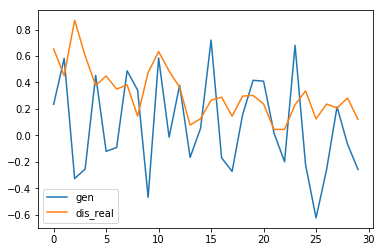

Generation 168  fitness : 185.74861282172338
#################################
population fitness : [  77.28801876   53.47280143  100.0818495   -88.16716892  -87.52630434
  -23.46964197  131.23732457   77.94415603  125.17225157 -109.09299985]
mean fit : 25.694028677413957
[0.1 0.  0.1 0.  0.1 0.  0.1 0.  0.  0. ]
5.627324887349232
Evolving...
Choice : [0, 7, 6, 6, 5, 3, 8, 2, 1, 4, 6]


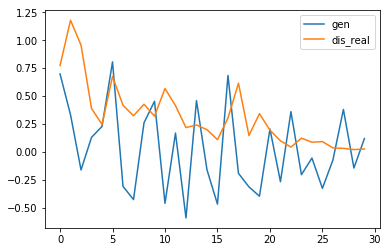

Generation 169  fitness : 131.23732457210593
#################################
population fitness : [181.62743262 -11.63402484 127.20496459 135.64117321  71.10220216
 103.87636604 192.1816111  -82.26018692 -90.55331628 -50.05036412]
mean fit : 57.713585755694865
[0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.1]
5.662092927438028
Evolving...
Choice : [1, 5, 6, 0, 9, 4, 3, 6, 2, 6, 7]


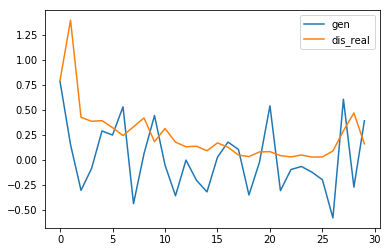

Generation 170  fitness : 192.18161109819818
#################################
population fitness : [104.75559176 -99.63931008 146.48487848 -26.36514397 -99.25950825
 -31.84887281 169.23835413  76.74296052 180.18268282 -43.64196203]
mean fit : 37.66496705652405
[0.1 0.1 0.1 0.  0.  0.1 0.1 0.1 0.1 0.1]
5.746682467099813
Evolving...
Choice : [3, 8, 7, 5, 9, 0, 6, 4, 2, 8, 8]


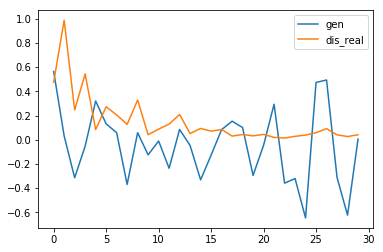

Generation 171  fitness : 180.18268282358883
#################################


KeyboardInterrupt: 

In [4]:
population_size = 10
max_population = 10
max_population_batch = 2
batch_size = 10
out_size = population_size
n_generations = 300000

#randomly inititialise starting population
population = []
for p in range(population_size):
    population.append(Creature(env.observation_space.shape[0],creature_out_size).to(device))

gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
for i in range(n_generations):
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001,betas=(0.5,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.5,0.999))
   
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch = ((fitness_batch - np.mean(fitness_batch))/np.sqrt(np.var(fitness_batch)+epsilon))
    
    #Train GAN
    gen_loss, dis_loss = train_gan(population_batch,fitness_batch,
              batch_size =min(batch_size,len(population_batch)//2),n_epochs = 15)
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0.1
    mutation_rate = 0.5
    mutation_rate = np.random.choice([0.1, 0], p_fitness_.shape,p=[mutation_rate,1-mutation_rate])
    print(mutation_rate)
    print(np.std(np.log(p_fitness_-np.min(p_fitness_)+epsilon)))
    #mutation_rate = np.ones(p_fitness_.shape)*0
    
    #progressively grow population at start
    if out_size < max_population:
        out_size+=2
    print("Evolving...")
    #mate and mutate population
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale)

    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_real')
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [6]:
env = gym.make(envs[-2]).unwrapped

p_fitness = measure_population_fitness(population,env,device,discrete_actions,min_reward=-100,
                                                             max_steps = 200)

fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,min_reward=-100,
                                  render = True,max_steps = 5000000)
print(fitness)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
243.73301981223403


In [ ]:
yeet= np.array([10,5,3,3.5,7,3,4,6,6])
print(len(yeet))
sort = np.argsort(np.max(yeet)-yeet)
out_size = 12
out = []

print(sort)

for i in range(out_size):
    ex = (out_size)/3
    ex = ex**(1/(i+1))
    print(i%(len(yeet)-1))
    for _ in range(int(ex)):
        out.append(sort[i%(len(yeet)-1)])
    if len(out) > out_size:
        out = out[:out_size]
        break
        
print()
print(yeet[out])

In [ ]:
yeet= np.array([10,5,3,3.5,7,3,4,6,6])
print(softmax(yeet))
